In [152]:
import os
import pickle
import sys
import warnings
from glob import glob
import re
import datetime
import itertools
from pyti.moving_average_convergence_divergence import moving_average_convergence_divergence as macd
from pyti.simple_moving_average import simple_moving_average as sma
from pyti.stochastic import percent_k as srv_k
from pyti.stochastic import percent_d as srv_d
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, DayLocator, DateFormatter
#from mpl_finance import candlestick2_ohlc, volume_overlay
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import lightgbm as lgb
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy.stats import spearmanr

In [2]:
dataset_dir="../data_dir/"

In [3]:
# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv",
    "stock_price": f"{dataset_dir}/stock_price.csv",
    "stock_fin": f"{dataset_dir}/stock_fin.csv",
    # 本チュートリアルでは使用しないため、コメントアウトしています。
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv",
    "stock_fin_growth_rate": f"{dataset_dir}/stock_fin_growth_rate.csv",
    "train_X": f"{dataset_dir}/train_X.csv",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels
stock_fin_growth_rate
train_X


In [79]:
def cross_X(x):
    return np.prod(x)

def get_features_for_predict(dfs, code, start_dt="2016-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # おおまかな手順の1つ目
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"]
    periods = [10, 20, 40]
    # 特定の銘柄コードのデータに絞る
    stock_fin = stock_fin[stock_fin["Local Code"] == code]
    fin_data = stock_fin[~stock_fin.duplicated(subset=['Local Code', 'Result_FinancialStatement ReportType',"Result_FinancialStatement FiscalYear"],keep='last')]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    seasons = stock_fin["Result_FinancialStatement ReportType"].unique()
    columns = fin_data.columns
    columns = columns.to_list()
    columns_list = ["Result_FinancialStatement NetSales","Result_FinancialStatement OrdinaryIncome","Result_FinancialStatement TotalAssets","Result_FinancialStatement NetAssets"]
    for column in columns_list:
        a = "last "+column
#         print(a)
#         print(type(columns))
        columns.append(a)
    df_result = pd.DataFrame(index=[], columns=columns)
    # columns_list.append("base_date")
    # columns_list.append("Local Code")
    for season in seasons:
        #df["last "+column] = 0
        #print(columns_list)
        df_test = fin_data[fin_data["Result_FinancialStatement ReportType"]==season].copy()
        for column in columns_list:
            #print(columns)
            df_test["last "+column] = df_test[column]
            df_test["last "+column] = df_test[column].shift()
            #df = pd.merge(df,df_test[["last "+column,"base_date","Local Code"]],on = ["base_date","Local Code"],how="left")
            #df_ab, df_ac, on='a', how='left'
        #print(df_result)
        #print(df_test)
        df_result = pd.concat([df_result,df_test])
    df_result["NetSales_growth_rate"] = df_result["Result_FinancialStatement NetSales"] / df_result["last Result_FinancialStatement NetSales"]
    df_result["OrdinaryIncome_growth_rate"] = df_result["Result_FinancialStatement OrdinaryIncome"] / df_result["last Result_FinancialStatement OrdinaryIncome"]
    df_result["TotalAssets_growth_rate"] = df_result["Result_FinancialStatement TotalAssets"] / df_result["last Result_FinancialStatement TotalAssets"]
    df_result["NetAssets_growth_rate"] = df_result["Result_FinancialStatement NetAssets"] / df_result["last Result_FinancialStatement NetAssets"]
    #df_result = df_result.drop(["EndOfDayQuote ExchangeOfficialClose","macd_hist_shift","stocas_hist_shift","stocas_huge_signal"], axis=1)
#     # fin_dataのnp.float64のデータのみを取得
#     fin_data = fin_data.select_dtypes(include=["float64"])
#     # 欠損値処理
#     fin_feats = fin_data.fillna(0)

    # おおまかな手順の2つ目
    # stock_priceデータを読み込む
    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_0.5month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(10).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    
    for period in periods:
        col = "5 windows volatility  {} mean".format(period)
        feats[col] = feats["volatility_0.5month"].rolling(period).mean()
    
    # ヒストリカル・ボラティリティ移動平均
    for period in periods:
        col = "25 windows volatility  {} mean".format(period)
        feats[col] = feats["volatility_1month"].rolling(period).mean()
        
    # ヒストリカル・ボラティリティ移動平均
    for period in periods:
        col = "75 windows volatility  {} mean".format(period)
        feats[col] = feats["volatility_2month"].rolling(period).mean()

    # ヒストリカル・ボラティリティ移動平均微分値
    for period in periods:
        col = "5 windows volatility  {} mean diff".format(period)
        feats[col] = feats["volatility_0.5month"].rolling(10).mean().pct_change(period)

    # ヒストリカル・ボラティリティ移動平均微分値
    for period in periods:
        col = "25 windows volatility  {} mean diff".format(period)
        feats[col] = feats["volatility_1month"].rolling(20).mean().pct_change(period)

    # ヒストリカル・ボラティリティ移動平均微分値
    for period in periods:
        col = "75 windows volatility  {} mean diff".format(period)
        feats[col] = feats["volatility_2month"].rolling(30).mean().pct_change(period)
    
    macd_period = {'long' : 26, 'short' : 12}
    sma_period  = 9
    feats['macd'] = macd(feats['EndOfDayQuote ExchangeOfficialClose'].values.tolist(), 12, 26)
    feats['macd_signal'] = sma(feats['macd'].values.tolist(), sma_period)
    feats["macd_hist"] = feats["macd"] - feats["macd_signal"]
    feats["macd_hist_shift"] = feats["macd_hist"].shift()
    feats.loc[feats["macd_hist"] < 0,"macd_hist_signal"] = -1
    feats.loc[feats["macd_hist"] > 0,"macd_hist_signal"] = 1
    feats.loc[feats["macd_hist"] == 0,"macd_hist_signal"] = 0
    feats["macd_cross_signal"] = feats["macd_hist"]*feats["macd_hist_shift"]
    feats.loc[feats["macd_cross_signal"] <= 0, "macd_cross_signal"] = 0
    feats.loc[feats["macd_cross_signal"] > 0, "macd_cross_signal"] = 1
    feats["macd_cross_sign_20"] = (1-feats["macd_cross_signal"].rolling(20).apply(cross_X))*feats["macd_hist_signal"]
    feats["macd_cross_sign_10"] = (1-feats["macd_cross_signal"].rolling(10).apply(cross_X))*feats["macd_hist_signal"]
    feats["macd_cross_sign_5"] = (1-feats["macd_cross_signal"].rolling(5).apply(cross_X))*feats["macd_hist_signal"]
    #feats.loc[feats["macd_cross_sign"] > 0, "macd_cross_sign"] = 1
    mac_cols = ["macd","macd_signal","macd_hist"]
    mac_cross_cols = ["macd_cross_sign_20","macd_cross_sign_10"]
    feats["slow%k"] = srv_d(feats["EndOfDayQuote ExchangeOfficialClose"].values.tolist(), 14)*100
    feats["slow%d"] = feats["slow%k"].rolling(3).mean()
    feats["stocas_hist"] = feats["slow%k"] - feats["slow%d"]
    feats["stocas_hist_shift"] = feats["stocas_hist"].shift()
    feats["stocas_cross_signal"] = feats["stocas_hist"]*feats["stocas_hist_shift"]
    feats.loc[feats["stocas_cross_signal"] <= 0, "stocas_cross_signal"] = 0
    feats.loc[feats["stocas_cross_signal"] > 0, "stocas_cross_signal"] = 1
    feats.loc[feats["stocas_hist"] < 0,"stocas_hist_signal"] = -1
    feats.loc[feats["stocas_hist"] > 0,"stocas_hist_signal"] = 1
    feats.loc[feats["stocas_hist"] == 0,"stocas_hist_signal"] = 0
    feats["stocas_huge_signal"] = 0
    feats.loc[feats["slow%k"] <= 20,"stocas_huge_signal"] = 1
    feats.loc[feats["slow%k"] >= 80,"stocas_huge_signal"] = 1
    
    # feats["stocas_cross_sign_20"] = (1-feats["stocas_cross_signal"].rolling(20).apply(cross_X))*feats["stocas_hist_signal"]*feats["stocas_huge_signal"]
    # feats["stocas_cross_sign_10"] = (1-feats["stocas_cross_signal"].rolling(10).apply(cross_X))*feats["stocas_hist_signal"]*feats["stocas_huge_signal"]
    feats["stocas_cross_sign_5"] = (1-feats["stocas_cross_signal"].rolling(5).apply(cross_X))*feats["stocas_hist_signal"]*feats["stocas_huge_signal"]
    
    
    # おおまかな手順の3つ目
    # 欠損値処理
    #feats = feats.fillna(0)
    # 元データのカラムを削除
    
    
    #財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(df_result.index)]
    df_result = df_result.loc[df_result.index.isin(feats.index)]
    feats = pd.merge(df_result,feats,left_index= True,right_index = True ,how = "left")
    stock_list = dfs["stock_list"]
    stock_data = stock_list[stock_list["Local Code"] == code]
    stock_data = stock_data[["33 Sector(Code)","17 Sector(Code)","IssuedShareEquityQuote IssuedShare","Size (New Index Series)"]]
    sector_17_dict = {1:0.041404, 2:0.056027, 3:0.052955, 4:0.064411, 5:0.091106, 6:0.046410, 7:0.047056, 8:0.070079, 9:0.052416, 10:0.061940, 11:0.062365, 12:0.052021,
                     13:0.022329, 14:0.030389, 15:0.190156, 16:0.109204, 17:0.083384}
    sector_33_dict = {50:	0.026789,
                        1050: 0.075618,
                        2050: 0.052140,
                        3050: 0.042869,
                        3100: 0.044244,
                        3150: 0.035982,
                        3200: 0.074299,
                        3250: 0.091106,
                        3300: 0.043225,
                        3350: 0.076820,
                        3400: 0.060586,
                        3450: 0.047813,
                        3500: 0.045698,
                        3550: 0.050873,
                        3600: 0.070079,
                        3650: 0.050197,
                        3700: 0.042787,
                        3750: 0.060784,
                        3800: 0.043177,
                        4050: 0.062365,
                        5050: 0.059168,
                        5100: 0.024505,
                        5150: 0.063092,
                        5200: 0.047985,
                        5250: 0.069475,
                        6050: 0.022329,
                        6100: 0.030389,
                        7050: 0.190156,
                        7100: 0.131484,
                        7150: 0.061564,
                        7200: 0.125792,
                        8050: 0.083384,
                        9050: 0.061318}
#     print("hello")
#     print(stock_data["33 Sector(Code)"])
    topix_dict = {'TOPIX Small 2':1, 'TOPIX Mid400':3, 'TOPIX Small 1':2, '-':0,'TOPIX Large70':4, 'TOPIX Core30':5}
    feats["en_33"] = sector_33_dict[stock_list["33 Sector(Code)"].values[0]]
    feats["en_17"] = sector_17_dict[stock_data["17 Sector(Code)"].values[0]]
    feats["Ordinary_rate_of_return"] = feats["Result_FinancialStatement OrdinaryIncome"] / feats["Result_FinancialStatement NetSales"]

    feats["sector17's_Ordinary_rate_of_return_diff"] = feats["Ordinary_rate_of_return"] - feats["en_33"]
    feats["sector33's_Ordinary_rate_of_return_diff"] = feats["Ordinary_rate_of_return"] - feats["en_17"]
    feats["en_topix"] = topix_dict[stock_data["Size (New Index Series)"].values[0]]
    feats["IssuedShareEquityQuote IssuedShare"] = stock_data["IssuedShareEquityQuote IssuedShare"]
    feats["Net_income_per_stock"] = feats["Result_FinancialStatement NetIncome"] / feats["IssuedShareEquityQuote IssuedShare"]
    #stock_data = stock_data["en_33","en_17","IssuedShareEquityQuote IssuedShare"]
    feats["PBR"] =feats["EndOfDayQuote ExchangeOfficialClose"] * feats["IssuedShareEquityQuote IssuedShare"] / feats["Result_FinancialStatement NetAssets"]
    feats["stability"] = feats["Result_FinancialStatement NetAssets"] / feats["Result_FinancialStatement TotalAssets"]
    feats["ROE"] = feats["Result_FinancialStatement NetIncome"] / feats["Result_FinancialStatement NetAssets"]
    feats["ROA"] = feats["Result_FinancialStatement NetIncome"] / feats["Result_FinancialStatement TotalAssets"]
    feats.loc[feats['Result_FinancialStatement CashFlowsFromOperatingActivities'] <= 0, 'Operating_cash_flow'] = 0
    feats.loc[feats['Result_FinancialStatement CashFlowsFromOperatingActivities'] > 0, 'Operating_cash_flow'] = 4
    feats.loc[feats['Result_FinancialStatement CashFlowsFromFinancingActivities'] <= 0, 'Financial_cash_flow'] = 0
    feats.loc[feats['Result_FinancialStatement CashFlowsFromFinancingActivities'] > 0, 'Financial_cash_flow'] = 1
    feats.loc[feats['Result_FinancialStatement CashFlowsFromInvestingActivities'] <= 0, 'Investing_cash_flow'] = 0
    feats.loc[feats['Result_FinancialStatement CashFlowsFromInvestingActivities'] > 0, 'Investing_cash_flow'] = 2
    feats["cash_evaluation"] = feats["Operating_cash_flow"] + feats["Financial_cash_flow"] + feats["Investing_cash_flow"]
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose","macd_hist_shift","stocas_hist_shift","stocas_huge_signal","Operating_cash_flow","Operating_cash_flow","Financial_cash_flow",
                       "Investing_cash_flow","macd_cross_signal","Result_FinancialStatement FiscalYear","Forecast_FinancialStatement FiscalYear","Forecast_Dividend FiscalYear","Result_Dividend FiscalYear"
                       ,"en_33","en_17","Ordinary_rate_of_return"], axis=1)
    


    feats = feats.select_dtypes(include=[int, float])
    feats = feats.astype('float64')
    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code


    return feats

In [80]:
df = get_features_for_predict(dfs, 9984)
df.T

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3700    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

2016-04-21  \
Result_FinancialStatement NetSales                  6.810206e+06   
Result_FinancialStatement OperatingIncome           8.753220e+05   
Result_FinancialStatement OrdinaryIncome            9.182140e+05   
Result_FinancialStatement NetIncome                 4.289720e+05   
Result_FinancialStatement TotalAssets               2.149765e+07   
Result_FinancialStatement NetAssets                 3.855507e+06   
Result_FinancialStatement CashFlowsFromOperatin...           NaN   
Result_FinancialStatement CashFlowsFromFinancin...           NaN   
Result_FinancialStatement CashFlowsFromInvestin...           NaN   
Forecast_FinancialStatement NetSales                         NaN   
Forecast_FinancialStatement OperatingIncome                  NaN   
Forecast_FinancialStatement OrdinaryIncome                   NaN   
Forecast_FinancialStatement NetIncome                        NaN   
Result_Dividend QuarterlyDividendPerShare                    NaN   
Result_Dividend AnnualDividendPerShare                       NaN   
Forecast_Dividend QuarterlyDividendPerShare         2.100000e+01   
Forecast_Dividend AnnualDividendPerShare            4.100000e+01   
last Result_FinancialStatement NetSales                      NaN   
last Result_FinancialStatement OrdinaryIncome                NaN   
last Result_FinancialStatement TotalAssets                   NaN   
last Result_FinancialStatement NetAssets                     NaN   
NetSales_growth_rate                                         NaN   
OrdinaryIncome_growth_rate                                   NaN   
TotalAssets_growth_rate                                      NaN   
NetAssets_growth_rate                                        NaN   
return_1month                                       8.908766e-02   
return_2month                                       1.441458e-01   
return_3month                                       2.555166e-01   
volatility_0.5month                                 2.185930e-02   
volatility_1month                                   1.717726e-02   
...                                                          ...   
25 windows volatility  10 mean diff                -3.112838e-01   
25 windows volatility  20 mean diff                -6.551138e-01   
25 windows volatility  40 mean diff                          NaN   
75 windows volatility  10 mean diff                          NaN   
75 windows volatility  20 mean diff                          NaN   
75 windows volatility  40 mean diff                          NaN   
macd                                                7.446321e+01   
macd_signal                                         3.240683e+01   
macd_hist                                           4.205638e+01   
macd_hist_signal                                    1.000000e+00   
macd_cross_sign_20                                  1.000000e+00   
macd_cross_sign_10                                  1.000000e+00   
macd_cross_sign_5                                   0.000000e+00   
slow%k                                              9.841061e+01   
slow%d                                              8.988374e+01   
stocas_hist                                         8.526871e+00   
stocas_cross_signal                                 0.000000e+00   
stocas_hist_signal                                  1.000000e+00   
stocas_cross_sign_5                                 1.000000e+00   
sector17's_Ordinary_rate_of_return_diff             1.080401e-01   
sector33's_Ordinary_rate_of_return_diff             7.288911e-02   
en_topix                                            5.000000e+00   
IssuedShareEquityQuote IssuedShare                           NaN   
Net_income_per_stock                                         NaN   
PBR                                                          NaN   
stability                                           1.793455e-01   
ROE                                                 1.112622e-01   
ROA                                       

In [86]:
TRAIN_END = "2018-12-31"
VAL_START = "2019-02-01"
VAL_END = "2019-12-01"
TEST_START = "2020-01-01"

In [87]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"]
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]

        # 特定の目的変数に絞る
        labels = stock_labels[label]
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割（ホールドアウト法）
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)

    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [88]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を入力し、分割データを取得
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3700    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
100%|██████████| 1/1 [00:00<00:00, 28.69it/s]

                                                      2016-04-21  \
Result_FinancialStatement NetSales                  6.810206e+06   
Result_FinancialStatement OperatingIncome           8.753220e+05   
Result_FinancialStatement OrdinaryIncome            9.182140e+05   
Result_FinancialStatement NetIncome                 4.289720e+05   
Result_FinancialStatement TotalAssets               2.149765e+07   
Result_FinancialStatement NetAssets                 3.855507e+06   
Result_FinancialStatement CashFlowsFromOperatin...           NaN   
Result_FinancialStatement CashFlowsFromFinancin...           NaN   
Result_FinancialStatement CashFlowsFromInvestin...           NaN   
Forecast_FinancialStatement NetSales                         NaN   
Forecast_FinancialStatement OperatingIncome                  NaN   
Forecast_FinancialStatement OrdinaryIncome                   NaN   
Forecast_FinancialStatement NetIncome                        NaN   
Result_Dividend QuarterlyDividendPerShare       

In [89]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [90]:
# 対象の目的変数を定義
labels = {
    "label_high_5",
    "label_high_10",
    "label_high_20",
    "label_low_5",
    "label_low_10",
    "label_low_20",
}
# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

  0%|          | 0/3523 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you 

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
0    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  0%|          | 3/3523 [00:00<12:50,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, 

hello
2    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3    6050
Name: 33 Sector(Code), dtype: int64


  0%|          | 4/3523 [00:00<12:27,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, 

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
5    50
Name: 33 Sector(Code), dtype: int64


  0%|          | 5/3523 [00:01<12:32,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, 

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
6    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
7    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
8    50
Name: 33 Sector(Code), dtype: int64


  0%|          | 8/3523 [00:01<12:02,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, 

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  0%|          | 9/3523 [00:01<13:19,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, 

hello
9    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  0%|          | 10/3523 [00:02<13:19,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
10    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
11    50
Name: 33 Sector(Code), dtype: int64


  0%|          | 11/3523 [00:02<12:42,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  0%|          | 12/3523 [00:02<13:21,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
12    50
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
13    2050
Name: 33 Sector(Code), dtype: int64


  0%|          | 13/3523 [00:02<12:44,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
14    2050
Name: 33 Sector(Code), dtype: int64


  0%|          | 14/3523 [00:03<12:52,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
15    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
16    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  0%|          | 17/3523 [00:03<12:39,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
17    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
18    2050
Name: 33 Sector(Code), dtype: int64


  1%|          | 18/3523 [00:03<12:12,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 19/3523 [00:04<13:25,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
19    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
20    2050
Name: 33 Sector(Code), dtype: int64


  1%|          | 20/3523 [00:04<12:50,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
21    2050
Name: 33 Sector(Code), dtype: int64


  1%|          | 21/3523 [00:04<12:44,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
22    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
23    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
25    2050
Name: 33 Sector(Code), dtype: int64


  1%|          | 24/3523 [00:05<11:57,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 25/3523 [00:05<13:15,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
26    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
27    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 26/3523 [00:05<12:53,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
28    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
29    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
30    2050
Name: 33 Sector(Code), dtype: int64


  1%|          | 29/3523 [00:06<11:47,  4.94it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
31    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
32    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
33    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 32/3523 [00:06<11:21,  5.13it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
34    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
36    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
37    1050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 36/3523 [00:07<12:12,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
38    1050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 37/3523 [00:07<13:23,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
39    1050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
40    1050
Name: 33 Sector(Code), dtype: int64


  1%|          | 38/3523 [00:08<12:47,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
41    1050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
42    1050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
43    2050
Name: 33 Sector(Code), dtype: int64


  1%|          | 41/3523 [00:08<12:31,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
44    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
45    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  1%|          | 44/3523 [00:09<13:12,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
46    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
47    2050
Name: 33 Sector(Code), dtype: int64


  1%|▏         | 45/3523 [00:09<12:47,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
48    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
49    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
50    2050
Name: 33 Sector(Code), dtype: int64


  1%|▏         | 48/3523 [00:10<12:16,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
51    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
52    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
53    2050
Name: 33 Sector(Code), dtype: int64


  1%|▏         | 51/3523 [00:10<12:45,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
54    2050
Name: 33 Sector(Code), dtype: int64


  1%|▏         | 52/3523 [00:11<13:02,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
55    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
56    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 55/3523 [00:11<13:18,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
57    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
58    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 56/3523 [00:12<12:46,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 57/3523 [00:12<13:49,  4.18it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
59    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 58/3523 [00:12<13:24,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
60    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
61    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 59/3523 [00:12<12:45,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 60/3523 [00:12<13:26,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
62    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
63    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 61/3523 [00:13<12:49,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
64    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
65    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 64/3523 [00:13<12:48,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
66    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
67    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 65/3523 [00:14<12:25,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
68    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
69    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 68/3523 [00:14<12:18,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
70    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
71    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 69/3523 [00:14<12:02,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
72    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
73    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
74    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 72/3523 [00:15<12:01,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
75    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
76    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
77    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 75/3523 [00:16<11:31,  4.99it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 76/3523 [00:16<12:53,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
78    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
79    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 77/3523 [00:16<12:25,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
80    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
81    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 80/3523 [00:17<13:02,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
82    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
83    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 81/3523 [00:17<12:25,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
84    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 82/3523 [00:17<12:28,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
85    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
86    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  2%|▏         | 85/3523 [00:18<12:06,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
87    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
88    2050
Name: 33 Sector(Code), dtype: int64


  2%|▏         | 86/3523 [00:18<11:53,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
89    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
90    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  3%|▎         | 89/3523 [00:19<12:56,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

hello
91    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
92    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 90/3523 [00:19<12:17,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
93    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 91/3523 [00:19<12:37,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
94    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
95    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
96    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  3%|▎         | 94/3523 [00:20<11:49,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
97    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
98    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
99    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
100    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
101    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 99/3523 [00:21<12:14,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour,

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


  3%|▎         | 100/3523 [00:21<12:31,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
102    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
103    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
104    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
105    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 103/3523 [00:22<12:29,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
106    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
107    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  3%|▎         | 106/3523 [00:22<11:55,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
108    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
109    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 107/3523 [00:22<11:37,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
110    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
111    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  3%|▎         | 110/3523 [00:23<12:45,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
112    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
113    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 111/3523 [00:23<12:12,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
114    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
115    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
116    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 114/3523 [00:24<12:21,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
117    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 115/3523 [00:24<12:27,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
118    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
119    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
120    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  3%|▎         | 118/3523 [00:25<11:39,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
121    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
123    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
124    2050
Name: 33 Sector(Code), dtype: int64


  3%|▎         | 121/3523 [00:25<12:11,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
125    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
126    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▎         | 124/3523 [00:26<12:44,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
127    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
128    2050
Name: 33 Sector(Code), dtype: int64


  4%|▎         | 125/3523 [00:26<12:09,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
129    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
130    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
131    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▎         | 128/3523 [00:27<11:39,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
132    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
133    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
134    2050
Name: 33 Sector(Code), dtype: int64


  4%|▎         | 131/3523 [00:27<11:15,  5.02it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▎         | 132/3523 [00:28<12:17,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
135    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
136    2050
Name: 33 Sector(Code), dtype: int64


  4%|▍         | 133/3523 [00:28<11:51,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▍         | 134/3523 [00:28<13:05,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
137    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
138    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
139    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
140    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
141    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
142    2050
Name: 33 Sector(Code), dtype: int64


  4%|▍         | 139/3523 [00:29<12:24,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
143    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
144    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▍         | 142/3523 [00:30<12:51,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
145    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
146    2050
Name: 33 Sector(Code), dtype: int64


  4%|▍         | 143/3523 [00:30<12:15,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
147    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
148    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
149    2050
Name: 33 Sector(Code), dtype: int64


  4%|▍         | 146/3523 [00:31<11:26,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▍         | 147/3523 [00:31<12:09,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
150    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▍         | 148/3523 [00:31<13:11,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
151    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
152    2050
Name: 33 Sector(Code), dtype: int64


  4%|▍         | 149/3523 [00:31<12:35,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
153    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
154    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
155    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
156    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▍         | 154/3523 [00:33<12:41,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
157    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
158    2050
Name: 33 Sector(Code), dtype: int64


  4%|▍         | 155/3523 [00:33<12:17,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
159    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
160    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  4%|▍         | 158/3523 [00:33<12:47,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
161    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
162    2050
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 159/3523 [00:34<12:12,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▍         | 160/3523 [00:34<13:17,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
163    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
164    3550
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 161/3523 [00:34<12:37,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
165    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
166    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
167    2050
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 164/3523 [00:35<12:15,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▍         | 165/3523 [00:35<13:18,  4.21it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
168    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
169    2050
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 166/3523 [00:35<12:31,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
170    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
171    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
172    2050
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 169/3523 [00:36<11:37,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▍         | 170/3523 [00:36<12:48,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
173    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
174    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▍         | 171/3523 [00:36<12:20,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▍         | 172/3523 [00:37<13:17,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
175    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
176    3050
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 173/3523 [00:37<12:32,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▍         | 174/3523 [00:37<13:26,  4.15it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
177    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
178    3050
Name: 33 Sector(Code), dtype: int64


  5%|▍         | 175/3523 [00:37<12:39,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
179    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
180    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
181    3050
Name: 33 Sector(Code), dtype: int64


  5%|▌         | 178/3523 [00:38<11:50,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
182    3050
Name: 33 Sector(Code), dtype: int64


  5%|▌         | 179/3523 [00:38<12:20,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
183    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
184    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
185    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
186    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▌         | 183/3523 [00:39<11:37,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
187    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
188    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
189    3050
Name: 33 Sector(Code), dtype: int64


  5%|▌         | 186/3523 [00:39<11:07,  5.00it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▌         | 187/3523 [00:40<12:30,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
190    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
191    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▌         | 188/3523 [00:40<12:06,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
192    9050
Name: 33 Sector(Code), dtype: int64


  5%|▌         | 189/3523 [00:40<11:58,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
193    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
194    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
195    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▌         | 192/3523 [00:41<11:23,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  5%|▌         | 193/3523 [00:41<12:39,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
196    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 194/3523 [00:41<12:19,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
197    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 195/3523 [00:42<13:19,  4.16it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
198    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
199    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 196/3523 [00:42<12:38,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
200    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 197/3523 [00:42<12:43,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
201    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
202    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 200/3523 [00:43<12:05,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
203    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
204    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 201/3523 [00:43<11:43,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
205    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
206    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 204/3523 [00:43<12:28,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
207    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
208    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 205/3523 [00:44<12:03,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 206/3523 [00:44<13:01,  4.24it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
209    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
210    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 207/3523 [00:44<12:20,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
211    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
212    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 210/3523 [00:45<12:36,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
213    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
214    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 211/3523 [00:45<12:05,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
215    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
216    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
217    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 215/3523 [00:46<12:30,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
218    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▌         | 216/3523 [00:46<12:21,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
219    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
220    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 217/3523 [00:46<11:49,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
221    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
222    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
223    9050
Name: 33 Sector(Code), dtype: int64


  6%|▌         | 220/3523 [00:47<11:09,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
224    9050
Name: 33 Sector(Code), dtype: int64


  6%|▋         | 221/3523 [00:47<11:14,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
225    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
226    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  6%|▋         | 224/3523 [00:48<12:22,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
227    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
228    9050
Name: 33 Sector(Code), dtype: int64


  6%|▋         | 225/3523 [00:48<11:53,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
229    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
230    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
231    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
232    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
233    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
234    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
235    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 232/3523 [00:49<12:00,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
236    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
237    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
238    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 235/3523 [00:50<12:08,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
239    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
240    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 238/3523 [00:51<11:43,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
241    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
242    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 239/3523 [00:51<11:31,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 240/3523 [00:51<12:28,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
243    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
244    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 241/3523 [00:51<11:54,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
245    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
246    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
247    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 244/3523 [00:52<12:02,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
248    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
249    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
250    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 247/3523 [00:53<11:21,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
251    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
252    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
253    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 250/3523 [00:53<11:10,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
254    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
255    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
256    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
257    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 254/3523 [00:54<11:47,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
258    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
259    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
260    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 257/3523 [00:55<11:50,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 258/3523 [00:55<12:51,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
261    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
262    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 259/3523 [00:55<12:17,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
263    3050
Name: 33 Sector(Code), dtype: int64


  7%|▋         | 260/3523 [00:56<12:23,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
264    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
265    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  7%|▋         | 262/3523 [00:56<12:26,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
266    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
267    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 265/3523 [00:57<12:39,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
268    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
269    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
270    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
271    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 268/3523 [00:57<11:21,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 269/3523 [00:58<12:31,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
272    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
273    9050
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 270/3523 [00:58<11:54,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
274    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
275    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 273/3523 [00:58<11:26,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
276    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
277    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 275/3523 [00:59<12:23,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
278    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
279    5250
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 276/3523 [00:59<11:51,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 277/3523 [00:59<12:48,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
280    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
281    5250
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 278/3523 [01:00<12:05,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
282    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
283    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
284    5250
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 281/3523 [01:00<11:10,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
285    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
286    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 284/3523 [01:01<11:56,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
287    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
288    5250
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 285/3523 [01:01<11:33,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
289    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
290    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
291    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 288/3523 [01:02<11:03,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
292    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
293    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 291/3523 [01:02<12:06,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
294    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
295    5250
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 292/3523 [01:02<11:35,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
296    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
297    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 295/3523 [01:03<12:00,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
298    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
299    5250
Name: 33 Sector(Code), dtype: int64


  8%|▊         | 296/3523 [01:03<11:37,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
300    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
301    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  8%|▊         | 299/3523 [01:04<11:21,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
302    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
303    9050
Name: 33 Sector(Code), dtype: int64


  9%|▊         | 300/3523 [01:04<11:07,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▊         | 301/3523 [01:04<11:51,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
304    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
305    9050
Name: 33 Sector(Code), dtype: int64


  9%|▊         | 302/3523 [01:05<11:25,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▊         | 303/3523 [01:05<12:06,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
306    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
307    9050
Name: 33 Sector(Code), dtype: int64


  9%|▊         | 304/3523 [01:05<11:41,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
308    9050
Name: 33 Sector(Code), dtype: int64


  9%|▊         | 305/3523 [01:05<11:33,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
309    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
310    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
311    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▉         | 309/3523 [01:06<11:50,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
312    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
313    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
314    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
315    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
316    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 313/3523 [01:07<11:47,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▉         | 314/3523 [01:07<12:48,  4.18it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
317    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
318    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 315/3523 [01:07<12:10,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
319    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
320    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
321    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▉         | 319/3523 [01:08<12:05,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
322    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
323    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 320/3523 [01:08<11:38,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
324    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
325    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
326    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 323/3523 [01:09<11:11,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
327    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
328    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
329    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
330    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
331    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 328/3523 [01:10<11:05,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
332    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
333    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▉         | 331/3523 [01:11<11:58,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
334    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
335    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 332/3523 [01:11<11:34,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  9%|▉         | 333/3523 [01:11<12:38,  4.21it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
336    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
337    9050
Name: 33 Sector(Code), dtype: int64


  9%|▉         | 334/3523 [01:12<12:02,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
338    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
339    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 10%|▉         | 337/3523 [01:12<12:11,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
340    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
341    9050
Name: 33 Sector(Code), dtype: int64


 10%|▉         | 338/3523 [01:12<11:41,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
342    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
343    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
344    9050
Name: 33 Sector(Code), dtype: int64


 10%|▉         | 341/3523 [01:13<11:13,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
345    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
346    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 10%|▉         | 344/3523 [01:14<11:33,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
347    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
348    9050
Name: 33 Sector(Code), dtype: int64


 10%|▉         | 345/3523 [01:14<11:11,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
349    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
350    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
351    9050
Name: 33 Sector(Code), dtype: int64


 10%|▉         | 348/3523 [01:14<11:08,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
352    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
353    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
354    9050
Name: 33 Sector(Code), dtype: int64


 10%|▉         | 351/3523 [01:15<11:00,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
355    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
356    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
357    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
358    5250
Name: 33 Sector(Code), dtype: int64


 10%|█         | 355/3523 [01:16<10:44,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 10%|█         | 356/3523 [01:16<11:40,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
359    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
360    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 10%|█         | 357/3523 [01:16<11:28,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
361    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
362    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
363    9050
Name: 33 Sector(Code), dtype: int64


 10%|█         | 360/3523 [01:17<11:37,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
364    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
365    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 10%|█         | 363/3523 [01:18<11:06,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
366    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
367    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
368    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
369    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 10%|█         | 367/3523 [01:18<11:07,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
370    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
371    3050
Name: 33 Sector(Code), dtype: int64


 10%|█         | 368/3523 [01:19<10:51,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
372    3050
Name: 33 Sector(Code), dtype: int64


 10%|█         | 369/3523 [01:19<11:07,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
373    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
374    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
375    3050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 372/3523 [01:20<11:26,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
376    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
377    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
378    3050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 375/3523 [01:20<11:36,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
379    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
380    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█         | 378/3523 [01:21<11:47,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
381    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
382    3050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 379/3523 [01:21<11:20,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█         | 380/3523 [01:21<12:09,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
383    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
384    3050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 381/3523 [01:22<11:37,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
385    3050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 382/3523 [01:22<11:31,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
386    3050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 383/3523 [01:22<11:37,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
387    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
388    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
389    6100
Name: 33 Sector(Code), dtype: int64


 11%|█         | 386/3523 [01:23<11:37,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█         | 387/3523 [01:23<12:27,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
390    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
391    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
392    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█         | 390/3523 [01:24<12:20,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
393    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
394    6100
Name: 33 Sector(Code), dtype: int64


 11%|█         | 391/3523 [01:24<11:42,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█         | 392/3523 [01:24<12:37,  4.14it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
395    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
396    6100
Name: 33 Sector(Code), dtype: int64


 11%|█         | 393/3523 [01:24<11:49,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
397    6050
Name: 33 Sector(Code), dtype: int64


 11%|█         | 394/3523 [01:24<11:34,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
398    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
399    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█▏        | 397/3523 [01:25<11:17,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
400    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
401    6100
Name: 33 Sector(Code), dtype: int64


 11%|█▏        | 398/3523 [01:25<10:53,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 11%|█▏        | 399/3523 [01:26<12:03,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
402    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
403    6100
Name: 33 Sector(Code), dtype: int64


 11%|█▏        | 400/3523 [01:26<11:33,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
404    6050
Name: 33 Sector(Code), dtype: int64


 11%|█▏        | 401/3523 [01:26<11:20,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 11%|█▏        | 402/3523 [01:26<11:43,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
405    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
406    6100
Name: 33 Sector(Code), dtype: int64


 11%|█▏        | 403/3523 [01:26<11:15,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
407    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
408    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 406/3523 [01:27<11:55,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
409    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
410    6100
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 407/3523 [01:27<11:25,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
411    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
412    6050
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 409/3523 [01:28<11:27,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
413    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
414    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
415    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
416    6100
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 413/3523 [01:29<11:27,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
417    6050
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 414/3523 [01:29<11:16,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
418    6100
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 415/3523 [01:29<11:21,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
419    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
420    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
421    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 418/3523 [01:30<10:50,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
422    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
423    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
424    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 421/3523 [01:30<10:29,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
425    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 422/3523 [01:30<10:34,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 423/3523 [01:31<11:46,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
426    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
427    6050
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 424/3523 [01:31<11:17,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
428    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
429    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 427/3523 [01:32<11:52,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
430    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
431    6100
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 428/3523 [01:32<11:20,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
432    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
433    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 431/3523 [01:33<11:48,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
434    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
435    6050
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 432/3523 [01:33<11:24,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
436    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
437    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
438    6050
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 435/3523 [01:33<11:02,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
439    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
440    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 12%|█▏        | 438/3523 [01:34<11:27,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
441    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
442    6100
Name: 33 Sector(Code), dtype: int64


 12%|█▏        | 439/3523 [01:34<11:01,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
443    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
444    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
445    6100
Name: 33 Sector(Code), dtype: int64


 13%|█▎        | 442/3523 [01:35<10:29,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
446    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
447    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 445/3523 [01:35<11:28,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
448    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
449    6050
Name: 33 Sector(Code), dtype: int64


 13%|█▎        | 446/3523 [01:36<11:01,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 447/3523 [01:36<11:52,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
450    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
451    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 448/3523 [01:36<11:23,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
452    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
453    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
454    6100
Name: 33 Sector(Code), dtype: int64


 13%|█▎        | 451/3523 [01:37<11:29,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
455    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
456    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 454/3523 [01:37<11:02,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
457    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
458    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 455/3523 [01:38<10:52,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
459    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
460    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
461    6100
Name: 33 Sector(Code), dtype: int64


 13%|█▎        | 458/3523 [01:38<10:45,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
462    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
463    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
464    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 461/3523 [01:39<10:24,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 462/3523 [01:39<11:33,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
465    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
466    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
467    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
468    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 466/3523 [01:40<11:02,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
469    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
470    3050
Name: 33 Sector(Code), dtype: int64


 13%|█▎        | 467/3523 [01:40<10:48,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
471    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
472    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 470/3523 [01:41<11:34,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
473    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
474    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 13%|█▎        | 472/3523 [01:41<11:57,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
475    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
476    3050
Name: 33 Sector(Code), dtype: int64


 13%|█▎        | 473/3523 [01:42<11:21,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
477    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
478    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
479    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▎        | 476/3523 [01:42<11:15,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▎        | 477/3523 [01:42<11:54,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
480    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
481    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▎        | 478/3523 [01:43<11:12,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▎        | 479/3523 [01:43<12:01,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
482    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
483    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▎        | 480/3523 [01:43<11:31,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
484    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▎        | 481/3523 [01:43<11:21,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
485    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
486    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
487    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▎        | 484/3523 [01:44<11:14,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
488    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
489    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
490    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 487/3523 [01:45<10:43,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
491    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
492    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
493    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 490/3523 [01:45<10:16,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
494    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 491/3523 [01:45<10:19,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
495    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
496    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▍        | 494/3523 [01:46<11:22,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
497    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
498    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▍        | 495/3523 [01:46<11:02,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
499    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
500    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▍        | 498/3523 [01:47<11:40,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
501    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
502    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 499/3523 [01:47<11:11,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
503    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
504    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▍        | 502/3523 [01:48<11:36,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
505    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
506    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 503/3523 [01:48<11:05,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 14%|█▍        | 504/3523 [01:48<12:01,  4.18it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
507    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
508    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 505/3523 [01:49<11:22,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
509    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
510    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
511    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 508/3523 [01:49<10:33,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
512    3050
Name: 33 Sector(Code), dtype: int64


 14%|█▍        | 509/3523 [01:49<10:41,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
513    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
514    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
515    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▍        | 512/3523 [01:50<10:08,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
516    3050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▍        | 513/3523 [01:50<10:22,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
517    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
518    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
520    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
528    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
529    3100
Name: 33 Sector(Code), dtype: int64


 15%|█▍        | 518/3523 [01:51<09:41,  5.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▍        | 519/3523 [01:51<10:35,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
530    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
531    6050
Name: 33 Sector(Code), dtype: int64


 15%|█▍        | 520/3523 [01:52<10:21,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
532    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
533    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
534    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
535    6100
Name: 33 Sector(Code), dtype: int64


 15%|█▍        | 524/3523 [01:52<10:12,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▍        | 525/3523 [01:53<11:16,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
536    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
537    6050
Name: 33 Sector(Code), dtype: int64


 15%|█▍        | 526/3523 [01:53<10:57,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▍        | 527/3523 [01:53<11:48,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
538    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
539    6100
Name: 33 Sector(Code), dtype: int64


 15%|█▍        | 528/3523 [01:53<11:18,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
540    5250
Name: 33 Sector(Code), dtype: int64


 15%|█▌        | 529/3523 [01:54<11:04,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
541    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
542    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▌        | 532/3523 [01:54<11:27,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
543    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
544    6050
Name: 33 Sector(Code), dtype: int64


 15%|█▌        | 533/3523 [01:54<10:59,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
545    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▌        | 535/3523 [01:55<11:12,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
546    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
547    5250
Name: 33 Sector(Code), dtype: int64


 15%|█▌        | 536/3523 [01:55<10:45,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
548    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
549    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▌        | 539/3523 [01:56<10:37,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
550    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
551    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▌        | 540/3523 [01:56<10:32,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
552    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
553    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 15%|█▌        | 543/3523 [01:57<10:55,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
554    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 15%|█▌        | 544/3523 [01:57<10:32,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
555    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
556    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
557    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 547/3523 [01:57<11:15,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
558    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
559    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 548/3523 [01:58<10:50,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
560    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 549/3523 [01:58<11:02,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
561    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
562    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
563    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 552/3523 [01:58<10:15,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
564    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 553/3523 [01:59<10:35,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
565    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
566    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 556/3523 [01:59<10:57,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
567    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
568    6050
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 557/3523 [02:00<10:33,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
569    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
570    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
571    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 560/3523 [02:00<10:50,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
572    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
573    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 563/3523 [02:01<10:40,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
574    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
575    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 564/3523 [02:01<10:24,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
576    6050
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 565/3523 [02:01<10:34,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
577    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
578    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 568/3523 [02:02<11:20,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
579    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
580    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 569/3523 [02:02<10:48,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
581    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▌        | 570/3523 [02:02<10:51,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
582    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▌        | 572/3523 [02:03<11:34,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
583    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
584    6100
Name: 33 Sector(Code), dtype: int64


 16%|█▋        | 573/3523 [02:03<11:01,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
585    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
586    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
587    3100
Name: 33 Sector(Code), dtype: int64


 16%|█▋        | 576/3523 [02:04<10:37,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 16%|█▋        | 577/3523 [02:04<10:57,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
588    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
589    3100
Name: 33 Sector(Code), dtype: int64


 16%|█▋        | 578/3523 [02:04<10:36,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 16%|█▋        | 579/3523 [02:04<11:28,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
590    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
591    3100
Name: 33 Sector(Code), dtype: int64


 16%|█▋        | 580/3523 [02:05<11:01,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
592    3400
Name: 33 Sector(Code), dtype: int64


 16%|█▋        | 581/3523 [02:05<10:58,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
593    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
594    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
595    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
596    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 17%|█▋        | 585/3523 [02:06<10:45,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
597    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
598    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
599    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
600    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
601    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 17%|█▋        | 591/3523 [02:07<11:17,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
602    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
603    6100
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 592/3523 [02:07<10:49,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
604    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
605    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
606    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
607    6050
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 596/3523 [02:08<10:16,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 17%|█▋        | 597/3523 [02:08<11:15,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
608    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 17%|█▋        | 598/3523 [02:09<10:57,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
609    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
610    6100
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 599/3523 [02:09<10:36,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
611    6050
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 600/3523 [02:09<10:48,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
612    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
613    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 17%|█▋        | 603/3523 [02:10<10:24,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
614    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
615    6050
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 604/3523 [02:10<10:08,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
616    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
617    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 17%|█▋        | 607/3523 [02:10<10:58,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
618    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
619    6050
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 608/3523 [02:11<10:32,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
620    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
621    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
622    6050
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 611/3523 [02:11<10:06,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
623    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
624    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
625    6050
Name: 33 Sector(Code), dtype: int64


 17%|█▋        | 614/3523 [02:12<10:20,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
626    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
627    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
628    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 617/3523 [02:13<09:50,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 618/3523 [02:13<10:54,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
629    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
630    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 619/3523 [02:13<10:27,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 620/3523 [02:13<11:22,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
631    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 621/3523 [02:14<11:55,  4.06it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
632    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
633    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 622/3523 [02:14<11:18,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
634    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 623/3523 [02:14<10:58,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
635    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
636    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
637    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 626/3523 [02:15<10:20,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
638    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 627/3523 [02:15<10:15,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
639    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
640    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
641    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
642    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
643    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
644    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 634/3523 [02:16<10:21,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
645    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
646    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 635/3523 [02:16<10:05,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
647    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 636/3523 [02:17<10:15,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
648    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
649    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
650    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 639/3523 [02:17<10:44,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
651    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
652    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
653    3100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 642/3523 [02:18<09:53,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
654    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
655    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
656    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 645/3523 [02:19<10:30,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 646/3523 [02:19<11:21,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
657    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
658    6100
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 647/3523 [02:19<10:49,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 18%|█▊        | 648/3523 [02:19<11:33,  4.15it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
659    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
660    8050
Name: 33 Sector(Code), dtype: int64


 18%|█▊        | 649/3523 [02:20<10:57,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
661    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
662    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
663    8050
Name: 33 Sector(Code), dtype: int64


 19%|█▊        | 652/3523 [02:20<10:26,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
664    8050
Name: 33 Sector(Code), dtype: int64


 19%|█▊        | 653/3523 [02:20<10:15,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▊        | 654/3523 [02:21<11:09,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
665    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
666    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▊        | 655/3523 [02:21<10:44,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
667    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
668    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
669    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▊        | 658/3523 [02:22<09:58,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
670    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
671    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
672    8050
Name: 33 Sector(Code), dtype: int64


 19%|█▉        | 661/3523 [02:22<09:52,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
673    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
674    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
675    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 664/3523 [02:23<09:39,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
676    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 665/3523 [02:23<09:58,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
677    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
678    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
679    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 668/3523 [02:24<09:42,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 669/3523 [02:24<10:35,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
680    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 670/3523 [02:24<11:21,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
681    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 19%|█▉        | 671/3523 [02:24<10:52,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


hello
682    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
683    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 672/3523 [02:25<10:26,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
684    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
685    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
686    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 675/3523 [02:25<09:57,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
687    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
688    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 678/3523 [02:26<10:35,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
689    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
690    8050
Name: 33 Sector(Code), dtype: int64


 19%|█▉        | 679/3523 [02:26<10:09,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
691    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
692    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 682/3523 [02:27<09:59,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
693    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
694    3300
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 683/3523 [02:27<09:53,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 19%|█▉        | 684/3523 [02:27<10:52,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
695    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
696    6100
Name: 33 Sector(Code), dtype: int64


 19%|█▉        | 685/3523 [02:27<10:21,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
697    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
698    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
699    6050
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 688/3523 [02:28<10:07,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
700    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
701    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
702    9050
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 691/3523 [02:29<09:34,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
703    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
704    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
705    6100
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 694/3523 [02:29<09:36,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
706    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
707    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 20%|█▉        | 697/3523 [02:30<09:39,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
708    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
709    6100
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 698/3523 [02:30<09:31,  4.94it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
710    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
711    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
712    6100
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 701/3523 [02:31<09:21,  5.02it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 20%|█▉        | 702/3523 [02:31<10:32,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
713    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
714    6050
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 703/3523 [02:31<10:05,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
715    6100
Name: 33 Sector(Code), dtype: int64


 20%|█▉        | 704/3523 [02:31<10:14,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
716    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
717    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
718    6100
Name: 33 Sector(Code), dtype: int64


 20%|██        | 707/3523 [02:32<10:07,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
719    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
720    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
721    6100
Name: 33 Sector(Code), dtype: int64


 20%|██        | 710/3523 [02:33<09:54,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
722    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
723    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
724    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
725    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
726    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 20%|██        | 715/3523 [02:33<09:24,  4.97it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
727    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
728    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 20%|██        | 718/3523 [02:34<10:34,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
729    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
730    6050
Name: 33 Sector(Code), dtype: int64


 20%|██        | 719/3523 [02:34<10:09,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
731    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
732    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
733    6050
Name: 33 Sector(Code), dtype: int64


 20%|██        | 722/3523 [02:35<09:54,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
734    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
735    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
736    6100
Name: 33 Sector(Code), dtype: int64


 21%|██        | 725/3523 [02:36<09:54,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
737    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
738    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
739    3100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 728/3523 [02:36<09:45,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
740    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
741    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 731/3523 [02:37<09:48,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
742    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
743    3100
Name: 33 Sector(Code), dtype: int64


 21%|██        | 732/3523 [02:37<09:36,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
744    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
745    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
746    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
747    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
748    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 738/3523 [02:38<10:00,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
749    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 739/3523 [02:39<09:56,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
750    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
751    3550
Name: 33 Sector(Code), dtype: int64


 21%|██        | 740/3523 [02:39<09:39,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
752    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
753    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
754    3550
Name: 33 Sector(Code), dtype: int64


 21%|██        | 743/3523 [02:39<09:55,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 744/3523 [02:40<10:27,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
755    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
756    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 745/3523 [02:40<10:11,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
757    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
758    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
760    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██        | 748/3523 [02:40<09:37,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
761    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
762    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
763    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██▏       | 751/3523 [02:41<09:20,  4.94it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
764    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
765    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 21%|██▏       | 754/3523 [02:42<09:41,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
767    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
768    8050
Name: 33 Sector(Code), dtype: int64


 21%|██▏       | 755/3523 [02:42<09:29,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
769    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
770    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
771    8050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 758/3523 [02:43<10:01,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
772    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
773    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
774    8050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 761/3523 [02:43<09:35,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
775    8050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 762/3523 [02:43<09:42,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
776    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
777    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
778    8050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 765/3523 [02:44<09:36,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
779    8050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 766/3523 [02:44<09:37,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
780    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
781    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
782    8050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 769/3523 [02:45<08:52,  5.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
783    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
784    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
785    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
786    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
787    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
788    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
789    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
790    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
791    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
792    3100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 22%|██▏       | 779/3523 [02:47<08:13,  5.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 22%|██▏       | 780/3523 [02:47<09:34,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
793    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
794    3100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
795    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
796    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
797    3100
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 784/3523 [02:48<09:27,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
798    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
799    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 22%|██▏       | 787/3523 [02:48<09:29,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
800    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
801    6100
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 788/3523 [02:48<09:21,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
802    6050
Name: 33 Sector(Code), dtype: int64


 22%|██▏       | 789/3523 [02:49<09:24,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
803    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
804    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
805    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
806    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
807    6100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 794/3523 [02:50<09:06,  5.00it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 795/3523 [02:50<10:01,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
808    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
809    6100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 796/3523 [02:50<09:42,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
810    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
811    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
812    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 799/3523 [02:51<09:31,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
813    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
814    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
815    3100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 802/3523 [02:51<09:31,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
816    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
817    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
818    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
819    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
820    6050
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 807/3523 [02:52<09:23,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
821    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
822    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
823    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 810/3523 [02:53<08:49,  5.12it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
824    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 811/3523 [02:53<09:09,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
825    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
826    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 814/3523 [02:54<09:13,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
827    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
828    3100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 815/3523 [02:54<09:09,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
829    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
830    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
831    3100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 818/3523 [02:55<09:35,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
832    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
833    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 821/3523 [02:55<10:14,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
834    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
835    3100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 822/3523 [02:56<09:53,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
836    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
837    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 825/3523 [02:56<10:29,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
838    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
839    3100
Name: 33 Sector(Code), dtype: int64


 23%|██▎       | 826/3523 [02:56<09:57,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 23%|██▎       | 827/3523 [02:57<10:46,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
840    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
841    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
842    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 24%|██▎       | 830/3523 [02:57<10:17,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
843    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
844    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▎       | 831/3523 [02:58<09:49,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
845    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
846    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
847    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▎       | 834/3523 [02:58<09:51,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
848    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
849    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
850    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
851    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 24%|██▍       | 839/3523 [02:59<10:11,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
852    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
853    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▍       | 840/3523 [03:00<09:47,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
854    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
855    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
856    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▍       | 843/3523 [03:00<09:28,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
857    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
858    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
859    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 24%|██▍       | 846/3523 [03:01<09:07,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
860    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
861    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 24%|██▍       | 849/3523 [03:01<09:45,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
862    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
863    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▍       | 850/3523 [03:02<09:32,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
864    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
865    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
866    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▍       | 853/3523 [03:02<09:52,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
867    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
868    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
869    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
870    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
871    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
872    5250
Name: 33 Sector(Code), dtype: int64


 24%|██▍       | 859/3523 [03:04<09:37,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
873    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
874    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
875    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 24%|██▍       | 862/3523 [03:04<09:06,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
876    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
877    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▍       | 865/3523 [03:05<09:36,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
878    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 25%|██▍       | 866/3523 [03:05<09:21,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
879    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
880    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
881    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
882    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▍       | 869/3523 [03:06<09:11,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
883    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
884    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
885    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▍       | 872/3523 [03:06<08:54,  4.96it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
886    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
887    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
888    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
889    5250
Name: 33 Sector(Code), dtype: int64


 25%|██▍       | 876/3523 [03:07<09:20,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
890    5250
Name: 33 Sector(Code), dtype: int64


 25%|██▍       | 877/3523 [03:07<09:34,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
891    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
892    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
893    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▍       | 880/3523 [03:08<09:05,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
894    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▌       | 881/3523 [03:08<09:05,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
895    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
896    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
897    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▌       | 884/3523 [03:09<08:57,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
898    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
899    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
900    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▌       | 887/3523 [03:09<08:59,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
901    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
902    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
903    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
904    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
905    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
906    3150
Name: 33 Sector(Code), dtype: int64


 25%|██▌       | 893/3523 [03:11<09:20,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
907    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
908    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 25%|██▌       | 896/3523 [03:11<09:23,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
909    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
910    5250
Name: 33 Sector(Code), dtype: int64


 25%|██▌       | 897/3523 [03:11<09:08,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
911    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
912    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
913    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▌       | 900/3523 [03:12<08:55,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
914    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
915    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
916    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
917    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 904/3523 [03:13<09:24,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
918    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
919    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
920    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 907/3523 [03:14<08:59,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▌       | 908/3523 [03:14<09:55,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
921    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
922    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 909/3523 [03:14<09:33,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
923    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
924    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
925    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 912/3523 [03:15<09:40,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
926    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
927    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▌       | 915/3523 [03:15<09:20,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
928    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▌       | 916/3523 [03:16<09:58,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
929    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
930    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 917/3523 [03:16<09:35,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▌       | 918/3523 [03:16<10:07,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
931    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▌       | 919/3523 [03:16<10:40,  4.07it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
932    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
933    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 920/3523 [03:17<10:00,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
934    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
935    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
936    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 923/3523 [03:17<09:03,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
937    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▌       | 924/3523 [03:17<09:27,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
938    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
939    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
940    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 26%|██▋       | 928/3523 [03:18<09:54,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
941    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
942    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▋       | 929/3523 [03:18<09:33,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
943    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
944    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
945    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▋       | 932/3523 [03:19<09:01,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
946    5250
Name: 33 Sector(Code), dtype: int64


 26%|██▋       | 933/3523 [03:19<09:08,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
947    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
949    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 27%|██▋       | 936/3523 [03:20<09:04,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
950    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
951    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 937/3523 [03:20<08:53,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
952    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
953    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
954    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 27%|██▋       | 941/3523 [03:21<09:14,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
955    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
956    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 942/3523 [03:21<09:02,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
957    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
958    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
959    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
960    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 946/3523 [03:22<08:55,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
961    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
962    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
963    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 949/3523 [03:23<08:51,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
964    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
965    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
966    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 27%|██▋       | 953/3523 [03:23<09:14,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
967    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
968    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 954/3523 [03:24<09:00,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
969    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
970    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to

hello
971    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
972    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
973    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
974    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 27%|██▋       | 961/3523 [03:25<09:13,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
975    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
976    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 962/3523 [03:25<08:55,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
977    5250
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 963/3523 [03:25<09:08,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
978    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
979    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 27%|██▋       | 966/3523 [03:26<09:12,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
980    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
981    3150
Name: 33 Sector(Code), dtype: int64


 27%|██▋       | 967/3523 [03:26<08:57,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
982    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
983    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
984    3150
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
985    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
986    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
987    3150
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 973/3523 [03:28<08:42,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
988    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
989    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 28%|██▊       | 976/3523 [03:28<08:57,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
990    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
991    3150
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 977/3523 [03:28<08:46,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
992    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
993    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
994    5250
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 980/3523 [03:29<08:47,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
995    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
996    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 28%|██▊       | 983/3523 [03:30<08:51,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
997    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
998    5250
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 984/3523 [03:30<08:42,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
999    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1000    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1001    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 28%|██▊       | 987/3523 [03:31<09:19,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1002    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1003    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1004    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1005    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1006    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1007    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1008    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1009    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1010    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 28%|██▊       | 997/3523 [03:33<09:22,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

hello
1011    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1012    5250
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 998/3523 [03:33<09:05,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1013    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1014    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1015    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1016    5250
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 1002/3523 [03:34<08:45,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 28%|██▊       | 1003/3523 [03:34<09:31,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1017    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1018    5250
Name: 33 Sector(Code), dtype: int64


 28%|██▊       | 1004/3523 [03:34<09:09,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1019    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1020    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▊       | 1007/3523 [03:35<09:21,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1021    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1022    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▊       | 1009/3523 [03:35<09:22,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1023    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1024    5250
Name: 33 Sector(Code), dtype: int64


 29%|██▊       | 1010/3523 [03:35<09:00,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1025    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1026    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1027    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▉       | 1013/3523 [03:36<09:09,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1028    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1029    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1030    5250
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1016/3523 [03:37<09:03,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1031    5250
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1017/3523 [03:37<09:11,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1032    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1033    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▉       | 1020/3523 [03:38<09:06,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1034    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1035    3150
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1021/3523 [03:38<08:49,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1036    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1037    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▉       | 1024/3523 [03:38<08:51,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1038    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1039    3150
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1025/3523 [03:39<08:40,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1040    3150
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1026/3523 [03:39<08:49,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1041    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1042    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▉       | 1029/3523 [03:39<09:21,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1043    3150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1044    5250
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1030/3523 [03:40<08:52,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1045    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1046    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▉       | 1033/3523 [03:40<09:00,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1047    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1048    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1049    5250
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1035/3523 [03:41<08:41,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1050    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1051    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1052    5250
Name: 33 Sector(Code), dtype: int64


 29%|██▉       | 1038/3523 [03:41<08:17,  4.99it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 29%|██▉       | 1039/3523 [03:42<08:51,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1053    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1054    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1040/3523 [03:42<08:27,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1055    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1041/3523 [03:42<08:31,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1056    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1057    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1058    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1044/3523 [03:42<08:11,  5.04it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1059    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1045/3523 [03:43<08:23,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1060    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1061    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1062    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1063    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1064    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1050/3523 [03:44<08:11,  5.03it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1065    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1066    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1067    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1053/3523 [03:44<07:55,  5.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1068    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1069    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1070    5250
Name: 33 Sector(Code), dtype: int64


 30%|██▉       | 1056/3523 [03:45<07:35,  5.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1071    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1072    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1073    5250
Name: 33 Sector(Code), dtype: int64


 30%|███       | 1059/3523 [03:45<07:27,  5.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1074    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1075    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1076    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1077    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1078    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1079    3200
Name: 33 Sector(Code), dtype: int64


 30%|███       | 1065/3523 [03:46<07:49,  5.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 30%|███       | 1066/3523 [03:47<08:57,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1080    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1090    3200
Name: 33 Sector(Code), dtype: int64


 30%|███       | 1067/3523 [03:47<08:43,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1091    3200
Name: 33 Sector(Code), dtype: int64


 30%|███       | 1068/3523 [03:47<08:38,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1092    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1093    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1094    3400
Name: 33 Sector(Code), dtype: int64


 30%|███       | 1071/3523 [03:48<08:42,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1095    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1096    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1097    3200
Name: 33 Sector(Code), dtype: int64


 30%|███       | 1074/3523 [03:48<08:33,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1098    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1075/3523 [03:49<08:46,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1099    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1076/3523 [03:49<08:52,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1100    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1101    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███       | 1079/3523 [03:50<09:18,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1102    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1103    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1080/3523 [03:50<08:56,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1104    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1115    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1116    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1117    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███       | 1085/3523 [03:51<09:11,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1118    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1119    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1086/3523 [03:51<08:50,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1120    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1121    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███       | 1089/3523 [03:52<09:00,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1122    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1123    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1090/3523 [03:52<08:42,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1124    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1125    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1126    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███       | 1093/3523 [03:52<08:20,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1127    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1128    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1129    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1096/3523 [03:53<08:38,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███       | 1097/3523 [03:53<09:28,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1130    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1131    3200
Name: 33 Sector(Code), dtype: int64


 31%|███       | 1098/3523 [03:54<09:00,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1132    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1133    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1134    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███▏      | 1101/3523 [03:54<08:27,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1135    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1136    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███▏      | 1104/3523 [03:55<08:28,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1137    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1138    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███▏      | 1105/3523 [03:55<08:20,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1139    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1140    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 31%|███▏      | 1108/3523 [03:56<09:11,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1141    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1142    3200
Name: 33 Sector(Code), dtype: int64


 31%|███▏      | 1109/3523 [03:56<08:52,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1143    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1110/3523 [03:56<08:56,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1144    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1153    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 32%|███▏      | 1113/3523 [03:57<08:37,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1154    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1155    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1114/3523 [03:57<08:25,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1156    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1157    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1158    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 32%|███▏      | 1117/3523 [03:58<08:25,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1159    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1160    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 32%|███▏      | 1120/3523 [03:58<08:05,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1161    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1162    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1163    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1164    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1123/3523 [03:59<07:56,  5.04it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1165    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1166    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1167    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 32%|███▏      | 1127/3523 [04:00<08:56,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1168    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1169    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1128/3523 [04:00<08:39,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1170    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1171    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1172    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1173    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1174    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1175    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1176    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 32%|███▏      | 1136/3523 [04:02<08:38,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1177    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1178    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1137/3523 [04:02<08:21,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1179    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1180    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 32%|███▏      | 1140/3523 [04:02<08:08,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1181    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1182    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1141/3523 [04:03<08:03,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1183    3200
Name: 33 Sector(Code), dtype: int64


 32%|███▏      | 1142/3523 [04:03<08:21,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1184    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1185    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 33%|███▎      | 1145/3523 [04:04<09:39,  4.10it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1186    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1187    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1188    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1190    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1191    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1192    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1193    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 33%|███▎      | 1152/3523 [04:05<08:16,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1194    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1195    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1196    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1197    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1198    9050
Name: 33 Sector(Code), dtype: int64


 33%|███▎      | 1156/3523 [04:06<08:02,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1199    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1200    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1201    5250
Name: 33 Sector(Code), dtype: int64


 33%|███▎      | 1159/3523 [04:06<08:35,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1202    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1203    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1204    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1205    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1206    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1207    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1208    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1209    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 33%|███▎      | 1168/3523 [04:08<08:49,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1210    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1211    9050
Name: 33 Sector(Code), dtype: int64


 33%|███▎      | 1169/3523 [04:09<08:30,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1212    9050
Name: 33 Sector(Code), dtype: int64


 33%|███▎      | 1170/3523 [04:09<08:28,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1213    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1214    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 33%|███▎      | 1173/3523 [04:09<08:40,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1215    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1216    9050
Name: 33 Sector(Code), dtype: int64


 33%|███▎      | 1174/3523 [04:10<08:22,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1217    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1218    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1219    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 33%|███▎      | 1177/3523 [04:10<08:02,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1220    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1221    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1222    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1223    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1224    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 34%|███▎      | 1182/3523 [04:11<08:10,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1225    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1226    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 34%|███▎      | 1185/3523 [04:12<08:03,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1227    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1228    5250
Name: 33 Sector(Code), dtype: int64


 34%|███▎      | 1186/3523 [04:12<07:57,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1229    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1230    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 34%|███▎      | 1189/3523 [04:13<07:59,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1231    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1232    5250
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1190/3523 [04:13<07:51,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1233    6100
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1191/3523 [04:13<08:02,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1234    7200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1235    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1236    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1237    3200
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1195/3523 [04:14<08:04,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1238    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1239    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1240    3200
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1198/3523 [04:15<08:04,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1241    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1242    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 34%|███▍      | 1201/3523 [04:15<08:49,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1243    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1244    3200
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1202/3523 [04:15<08:28,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1245    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1246    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1247    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1248    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1249    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1250    5250
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1208/3523 [04:16<06:55,  5.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1251    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1252    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1253    5250
Name: 33 Sector(Code), dtype: int64


 34%|███▍      | 1211/3523 [04:17<07:07,  5.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1254    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1255    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1256    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 34%|███▍      | 1214/3523 [04:18<07:02,  5.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1257    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1258    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1259    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1260    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1261    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1262    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1263    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1264    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1265    3200
Name: 33 Sector(Code), dtype: int64


 35%|███▍      | 1223/3523 [04:19<07:09,  5.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1266    3050
Name: 33 Sector(Code), dtype: int64


 35%|███▍      | 1224/3523 [04:19<07:38,  5.01it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1267    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1268    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 35%|███▍      | 1227/3523 [04:20<07:41,  4.97it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1269    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1270    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1271    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1272    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1273    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1274    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1275    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1276    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1277    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 35%|███▌      | 1236/3523 [04:22<07:07,  5.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1298    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1299    3200
Name: 33 Sector(Code), dtype: int64


 35%|███▌      | 1237/3523 [04:22<07:13,  5.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1300    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1301    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 35%|███▌      | 1240/3523 [04:22<08:20,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1302    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1303    3200
Name: 33 Sector(Code), dtype: int64


 35%|███▌      | 1241/3523 [04:23<08:05,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1304    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1328    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 35%|███▌      | 1244/3523 [04:23<08:37,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1329    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1330    3250
Name: 33 Sector(Code), dtype: int64


 35%|███▌      | 1245/3523 [04:24<08:18,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1331    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1332    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 35%|███▌      | 1248/3523 [04:24<08:41,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1333    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1334    3250
Name: 33 Sector(Code), dtype: int64


 35%|███▌      | 1249/3523 [04:24<08:20,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1335    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1336    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1337    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 36%|███▌      | 1252/3523 [04:25<07:53,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1338    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1339    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 36%|███▌      | 1255/3523 [04:26<08:22,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1340    3050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1341    3250
Name: 33 Sector(Code), dtype: int64


 36%|███▌      | 1256/3523 [04:26<08:05,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1342    3250
Name: 33 Sector(Code), dtype: int64


 36%|███▌      | 1257/3523 [04:26<08:05,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1343    3250
Name: 33 Sector(Code), dtype: int64


 36%|███▌      | 1258/3523 [04:26<08:03,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1344    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1345    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 36%|███▌      | 1261/3523 [04:27<07:45,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1346    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello

 36%|███▌      | 1262/3523 [04:27<07:43,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning



1347    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1348    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1349    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1350    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1351    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 36%|███▌      | 1266/3523 [04:28<07:39,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1352    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1353    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1354    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1355    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1356    3250
Name: 33 Sector(Code), dtype: int64


 36%|███▌      | 1271/3523 [04:29<07:33,  4.96it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1357    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1358    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1359    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1360    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1361    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1362    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1363    3250
Name: 33 Sector(Code), dtype: int64


 36%|███▋      | 1278/3523 [04:30<07:42,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1364    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1365    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1366    3250
Name: 33 Sector(Code), dtype: int64


 36%|███▋      | 1281/3523 [04:31<07:38,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1367    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1368    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 36%|███▋      | 1284/3523 [04:32<08:10,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


hello
1369    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1370    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1371    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1372    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1373    3250
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1288/3523 [04:32<07:42,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1374    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1375    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1376    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 37%|███▋      | 1291/3523 [04:33<07:36,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1377    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1378    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1379    3250
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1294/3523 [04:34<07:32,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1380    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1381    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1382    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1383    3250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1384    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1385    3250
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1300/3523 [04:35<07:35,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1386    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1387    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1388    3250
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1303/3523 [04:36<07:34,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1389    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1390    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1391    3250
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1306/3523 [04:36<08:04,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1392    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1393    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1394    3250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1396    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1397    3200
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1311/3523 [04:37<07:37,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1398    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1399    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1400    3200
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1314/3523 [04:38<07:30,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1401    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1402    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1403    3200
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1317/3523 [04:38<07:24,  4.96it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1404    3200
Name: 33 Sector(Code), dtype: int64


 37%|███▋      | 1318/3523 [04:39<07:31,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1405    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1406    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1407    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 37%|███▋      | 1321/3523 [04:39<07:29,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1408    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1409    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1410    3200
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1324/3523 [04:40<07:48,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1325/3523 [04:40<08:25,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1411    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1326/3523 [04:40<08:09,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1412    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1413    3200
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1327/3523 [04:41<07:53,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1414    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1415    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1416    3200
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1330/3523 [04:41<07:32,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1331/3523 [04:42<08:22,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1417    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1418    9050
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1332/3523 [04:42<08:02,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1419    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1420    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1335/3523 [04:42<07:40,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1421    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1422    9050
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1336/3523 [04:43<07:34,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1423    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1424    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1339/3523 [04:43<08:04,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1425    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1426    9050
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1340/3523 [04:43<07:47,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1427    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1428    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1429    5250
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1343/3523 [04:44<07:24,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1430    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1431    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1346/3523 [04:45<07:22,  4.91it/s]

hello
1432    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1433    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1434    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1349/3523 [04:45<08:13,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1435    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1436    9050
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1350/3523 [04:45<07:55,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1437    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1438    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1353/3523 [04:46<08:20,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1439    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 38%|███▊      | 1354/3523 [04:46<08:14,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1440    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1441    9050
Name: 33 Sector(Code), dtype: int64


 38%|███▊      | 1355/3523 [04:47<07:53,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1442    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1443    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1444    5250
Name: 33 Sector(Code), dtype: int64


 39%|███▊      | 1358/3523 [04:47<07:53,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1445    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1446    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1447    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▊      | 1361/3523 [04:48<07:30,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1448    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▊      | 1362/3523 [04:48<07:51,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1449    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1451    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▊      | 1365/3523 [04:49<08:04,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1452    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1453    9050
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1366/3523 [04:49<07:45,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1454    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1455    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1456    9050
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1369/3523 [04:50<07:59,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1457    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1458    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1459    9050
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1372/3523 [04:50<07:26,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1460    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1461    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▉      | 1375/3523 [04:51<07:56,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1462    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1463    5250
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1376/3523 [04:51<07:42,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1464    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1465    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1466    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▉      | 1380/3523 [04:52<08:08,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1467    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1468    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▉      | 1381/3523 [04:52<07:52,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▉      | 1382/3523 [04:52<08:11,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1469    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1470    5250
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1383/3523 [04:53<07:51,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1471    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1472    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 39%|███▉      | 1386/3523 [04:53<07:44,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1473    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1474    5250
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1387/3523 [04:53<07:32,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1475    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1476    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1477    5250
Name: 33 Sector(Code), dtype: int64


 39%|███▉      | 1390/3523 [04:54<07:15,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1478    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1479    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1480    9050
Name: 33 Sector(Code), dtype: int64


 40%|███▉      | 1393/3523 [04:55<07:46,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1481    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1482    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 40%|███▉      | 1396/3523 [04:55<07:53,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1483    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1484    9050
Name: 33 Sector(Code), dtype: int64


 40%|███▉      | 1397/3523 [04:56<07:36,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1485    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1486    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1487    9050
Name: 33 Sector(Code), dtype: int64


 40%|███▉      | 1400/3523 [04:56<07:39,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1488    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1489    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1490    9050
Name: 33 Sector(Code), dtype: int64


 40%|███▉      | 1403/3523 [04:57<07:16,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1491    9050
Name: 33 Sector(Code), dtype: int64


 40%|███▉      | 1404/3523 [04:57<07:25,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1492    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1493    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1494    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 40%|███▉      | 1407/3523 [04:58<07:11,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1495    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 40%|███▉      | 1408/3523 [04:58<07:22,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1496    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1497    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1498    5250
Name: 33 Sector(Code), dtype: int64


 40%|████      | 1411/3523 [04:59<07:48,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1499    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1500    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1501    5250
Name: 33 Sector(Code), dtype: int64


 40%|████      | 1414/3523 [04:59<07:14,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1502    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1503    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1504    5250
Name: 33 Sector(Code), dtype: int64


 40%|████      | 1417/3523 [05:00<07:35,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1505    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1506    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1507    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 40%|████      | 1420/3523 [05:01<07:50,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 40%|████      | 1421/3523 [05:01<08:11,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1508    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1509    5250
Name: 33 Sector(Code), dtype: int64


 40%|████      | 1422/3523 [05:01<07:47,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1510    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1511    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1512    5250
Name: 33 Sector(Code), dtype: int64


 40%|████      | 1425/3523 [05:02<07:39,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1513    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1514    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1515    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1428/3523 [05:02<07:17,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1516    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1517    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1431/3523 [05:03<07:21,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1518    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1519    9050
Name: 33 Sector(Code), dtype: int64


 41%|████      | 1432/3523 [05:03<07:12,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1520    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1521    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1435/3523 [05:04<08:01,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1522    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1436/3523 [05:04<07:47,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1523    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1524    5250
Name: 33 Sector(Code), dtype: int64


 41%|████      | 1437/3523 [05:04<07:33,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1525    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1439/3523 [05:05<08:08,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1526    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1527    9050
Name: 33 Sector(Code), dtype: int64


 41%|████      | 1440/3523 [05:05<07:44,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1532    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1533    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1534    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1443/3523 [05:05<07:16,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1444/3523 [05:06<07:59,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1535    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1536    3200
Name: 33 Sector(Code), dtype: int64


 41%|████      | 1445/3523 [05:06<07:38,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1537    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1538    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1448/3523 [05:07<07:55,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1539    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1540    3200
Name: 33 Sector(Code), dtype: int64


 41%|████      | 1449/3523 [05:07<07:35,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1541    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1542    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 41%|████      | 1452/3523 [05:07<07:39,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1543    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1544    3200
Name: 33 Sector(Code), dtype: int64


 41%|████      | 1453/3523 [05:08<07:29,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 41%|████▏     | 1454/3523 [05:08<07:43,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1545    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 41%|████▏     | 1455/3523 [05:08<07:25,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1546    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1547    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1548    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1554    3200
Name: 33 Sector(Code), dtype: int64


 41%|████▏     | 1458/3523 [05:09<07:05,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1555    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1556    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1557    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1558    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1559    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1560    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1561    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1465/3523 [05:10<07:06,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: 

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1562    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1466/3523 [05:10<07:17,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1563    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1564    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1469/3523 [05:11<07:09,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1565    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1566    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1470/3523 [05:11<07:02,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1567    3200
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1471/3523 [05:11<07:05,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1568    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1569    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1570    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1571    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1572    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1476/3523 [05:12<07:01,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1573    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1574    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1575    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1479/3523 [05:13<07:29,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1576    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1577    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1578    3200
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1482/3523 [05:14<07:02,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1579    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1580    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1581    3200
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1485/3523 [05:14<07:25,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1582    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1583    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1584    3200
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1488/3523 [05:15<07:33,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1585    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1586    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1587    6050
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1491/3523 [05:16<07:25,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1492/3523 [05:16<07:58,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1588    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1589    3300
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1493/3523 [05:16<07:39,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1590    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1591    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 42%|████▏     | 1496/3523 [05:17<07:54,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1592    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1593    3300
Name: 33 Sector(Code), dtype: int64


 42%|████▏     | 1497/3523 [05:17<07:34,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1498/3523 [05:17<08:19,  4.05it/s]

hello
1594    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1595    3300
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1596    3300
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1599    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1600    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1601    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1602    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1603    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1604    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1605    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1606    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1607    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1608    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1609    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1610    3350
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1512/3523 [05:20<06:50,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1611    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1612    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1613    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1515/3523 [05:21<06:50,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1614    3350
Name: 33 Sector(Code), dtype: int64


 43%|████▎     | 1516/3523 [05:21<06:53,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1615    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1616    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1519/3523 [05:22<07:33,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1617    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1618    3350
Name: 33 Sector(Code), dtype: int64


 43%|████▎     | 1520/3523 [05:22<07:18,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1521/3523 [05:22<07:42,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1619    3350
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1522/3523 [05:23<07:42,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1620    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1621    3400
Name: 33 Sector(Code), dtype: int64


 43%|████▎     | 1523/3523 [05:23<07:22,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1622    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1623    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1624    3400
Name: 33 Sector(Code), dtype: int64


 43%|████▎     | 1526/3523 [05:23<07:18,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1625    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1626    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1529/3523 [05:24<07:34,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1627    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 43%|████▎     | 1530/3523 [05:24<07:44,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1628    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1629    3400
Name: 33 Sector(Code), dtype: int64


 43%|████▎     | 1531/3523 [05:25<07:26,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1630    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1631    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▎     | 1534/3523 [05:25<07:42,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1632    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1633    9050
Name: 33 Sector(Code), dtype: int64


 44%|████▎     | 1535/3523 [05:25<07:24,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1634    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1635    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1636    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▎     | 1538/3523 [05:26<06:56,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1637    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1638    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1639    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▎     | 1541/3523 [05:27<06:47,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1640    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1641    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1543/3523 [05:27<06:49,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1642    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1544/3523 [05:27<06:58,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1643    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1644    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1547/3523 [05:28<06:49,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1645    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1548/3523 [05:28<07:29,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1646    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1647    3400
Name: 33 Sector(Code), dtype: int64


 44%|████▍     | 1549/3523 [05:28<07:11,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1648    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1649    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1650    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1553/3523 [05:29<07:33,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1651    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1652    3400
Name: 33 Sector(Code), dtype: int64


 44%|████▍     | 1554/3523 [05:29<07:15,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1653    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1654    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1655    3400
Name: 33 Sector(Code), dtype: int64


 44%|████▍     | 1557/3523 [05:30<06:48,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1656    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1657    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1560/3523 [05:31<06:52,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1658    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1659    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1561/3523 [05:31<06:50,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1660    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1661    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1662    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1564/3523 [05:31<06:37,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1663    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1664    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1665    3400
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 44%|████▍     | 1567/3523 [05:32<06:29,  5.02it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▍     | 1568/3523 [05:32<07:04,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1666    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1668    3400
Name: 33 Sector(Code), dtype: int64


 45%|████▍     | 1569/3523 [05:33<06:55,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▍     | 1570/3523 [05:33<07:35,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1669    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1670    3400
Name: 33 Sector(Code), dtype: int64


 45%|████▍     | 1571/3523 [05:33<07:15,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1671    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1672    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▍     | 1574/3523 [05:34<07:31,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1673    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▍     | 1575/3523 [05:34<07:34,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1674    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1675    3400
Name: 33 Sector(Code), dtype: int64


 45%|████▍     | 1576/3523 [05:34<07:15,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1676    3400
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1677    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1678    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1679    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1680    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1681    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1682    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1683    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1684    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1685    3450
Name: 33 Sector(Code), dtype: int64


 45%|████▌     | 1586/3523 [05:36<06:59,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1686    3450
Name: 33 Sector(Code), dtype: int64


 45%|████▌     | 1587/3523 [05:36<06:54,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1687    3450
Name: 33 Sector(Code), dtype: int64


 45%|████▌     | 1588/3523 [05:37<06:57,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1688    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1689    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1690    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▌     | 1591/3523 [05:37<06:38,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1691    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1692    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1693    3450
Name: 33 Sector(Code), dtype: int64


 45%|████▌     | 1594/3523 [05:38<06:31,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▌     | 1595/3523 [05:38<07:17,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1694    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1695    3450
Name: 33 Sector(Code), dtype: int64


 45%|████▌     | 1596/3523 [05:38<07:03,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1696    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1697    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▌     | 1599/3523 [05:39<06:44,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1698    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1699    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 45%|████▌     | 1600/3523 [05:39<06:38,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1700    3450
Name: 33 Sector(Code), dtype: int64


 45%|████▌     | 1601/3523 [05:39<06:38,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1701    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1702    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▌     | 1604/3523 [05:40<06:41,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1703    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1704    3450
Name: 33 Sector(Code), dtype: int64


 46%|████▌     | 1605/3523 [05:40<06:36,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1705    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1706    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▌     | 1608/3523 [05:41<06:58,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1707    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1708    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▌     | 1609/3523 [05:41<06:51,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1709    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1710    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1711    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1712    3450
Name: 33 Sector(Code), dtype: int64


 46%|████▌     | 1613/3523 [05:42<06:33,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1713    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1714    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1716    3450
Name: 33 Sector(Code), dtype: int64


 46%|████▌     | 1616/3523 [05:43<06:54,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1717    3450
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1718    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1719    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1720    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1721    3500
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▌     | 1621/3523 [05:44<06:20,  5.00it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1722    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1723    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▌     | 1624/3523 [05:44<07:12,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1724    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1725    3500
Name: 33 Sector(Code), dtype: int64


 46%|████▌     | 1625/3523 [05:44<06:59,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1726    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1727    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1728    3500
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▌     | 1628/3523 [05:45<06:41,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1729    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1730    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1731    3500
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▋     | 1631/3523 [05:46<06:25,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1732    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1733    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1734    3500
Name: 33 Sector(Code), dtype: int64


 46%|████▋     | 1634/3523 [05:46<06:36,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1735    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1736    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▋     | 1637/3523 [05:47<06:40,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1737    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 46%|████▋     | 1638/3523 [05:47<06:41,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1738    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1639/3523 [05:47<06:47,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1739    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1740    3500
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1640/3523 [05:48<06:41,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1741    3500
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1641/3523 [05:48<06:43,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1742    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1743    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1744    3500
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1644/3523 [05:48<06:28,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1745    3500
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1645/3523 [05:49<06:27,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1746    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1747    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1648/3523 [05:49<06:41,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1748    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1749    3500
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1649/3523 [05:49<06:39,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1750    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1751    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1752    6100
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1652/3523 [05:50<06:40,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1753    3500
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1754    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1655/3523 [05:51<07:10,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1755    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1756    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1656/3523 [05:51<06:54,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1757    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1758    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1759    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1760    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1660/3523 [05:52<06:25,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 47%|████▋     | 1661/3523 [05:52<06:44,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1761    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1762    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1662/3523 [05:52<06:38,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1763    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1764    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1765    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1665/3523 [05:53<06:27,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 47%|████▋     | 1666/3523 [05:53<06:44,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1766    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1767    3550
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1667/3523 [05:53<06:35,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 47%|████▋     | 1668/3523 [05:54<07:11,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1768    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1769    3550
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1669/3523 [05:54<06:53,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1770    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1771    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1772    3550
Name: 33 Sector(Code), dtype: int64


 47%|████▋     | 1672/3523 [05:54<06:35,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1773    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1774    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1675/3523 [05:55<06:42,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1775    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1776    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1676/3523 [05:55<06:32,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1777    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1778    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1779    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1679/3523 [05:56<06:21,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1780    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1781    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1682/3523 [05:56<06:48,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: 

hello
1782    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1783    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1683/3523 [05:57<06:36,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1784    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1785    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1786    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1686/3523 [05:57<06:52,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1787    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1788    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1689/3523 [05:58<07:03,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1789    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1790    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1690/3523 [05:58<06:47,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1791    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1792    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1693/3523 [05:59<06:41,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1793    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1694/3523 [05:59<06:42,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1794    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1795    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1695/3523 [05:59<06:31,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1796    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1797    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1697/3523 [06:00<06:35,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1798    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1799    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1700/3523 [06:00<06:56,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1800    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1801    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1701/3523 [06:01<06:39,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1802    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1803    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1704/3523 [06:01<07:01,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1804    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1805    3550
Name: 33 Sector(Code), dtype: int64


 48%|████▊     | 1705/3523 [06:01<06:42,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1806    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1807    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 48%|████▊     | 1708/3523 [06:02<06:58,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1808    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1809    3550
Name: 33 Sector(Code), dtype: int64


 49%|████▊     | 1709/3523 [06:02<06:43,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1810    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1811    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1812    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1813    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1814    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1815    3550
Name: 33 Sector(Code), dtype: int64


 49%|████▊     | 1715/3523 [06:04<06:28,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1816    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1817    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1818    3550
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1718/3523 [06:04<06:08,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 49%|████▉     | 1719/3523 [06:05<06:49,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1819    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1820    3550
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1720/3523 [06:05<06:35,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1821    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1822    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1823    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 49%|████▉     | 1723/3523 [06:05<06:12,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1824    3700
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1724/3523 [06:06<06:15,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1825    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1826    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 49%|████▉     | 1727/3523 [06:06<06:47,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1827    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1828    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1728/3523 [06:06<06:32,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 49%|████▉     | 1729/3523 [06:07<07:07,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1829    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1830    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1730/3523 [06:07<06:49,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1831    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1832    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 49%|████▉     | 1733/3523 [06:08<06:52,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1833    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1834    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1734/3523 [06:08<06:35,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1835    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1836    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1837    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1737/3523 [06:08<06:11,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1838    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1738/3523 [06:09<06:10,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1839    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1739/3523 [06:09<06:21,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1840    9050
Name: 33 Sector(Code), dtype: int64


 49%|████▉     | 1740/3523 [06:09<06:19,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1841    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1842    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1843    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1844    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|████▉     | 1745/3523 [06:10<06:24,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1845    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1846    9050
Name: 33 Sector(Code), dtype: int64


 50%|████▉     | 1746/3523 [06:10<06:15,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1847    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1848    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1849    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|████▉     | 1749/3523 [06:11<06:00,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1850    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1851    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1852    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|████▉     | 1753/3523 [06:12<06:22,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1853    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1854    9050
Name: 33 Sector(Code), dtype: int64


 50%|████▉     | 1754/3523 [06:12<06:14,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1855    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1856    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1857    9050
Name: 33 Sector(Code), dtype: int64


 50%|████▉     | 1757/3523 [06:13<06:18,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1858    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1859    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1860    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1861    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|████▉     | 1761/3523 [06:13<06:04,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|█████     | 1762/3523 [06:14<06:38,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1862    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1863    9050
Name: 33 Sector(Code), dtype: int64


 50%|█████     | 1763/3523 [06:14<06:25,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1864    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1865    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|█████     | 1766/3523 [06:14<06:09,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1866    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1867    9050
Name: 33 Sector(Code), dtype: int64


 50%|█████     | 1767/3523 [06:15<06:02,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1868    9050
Name: 33 Sector(Code), dtype: int64


 50%|█████     | 1768/3523 [06:15<06:02,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1869    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1870    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|█████     | 1771/3523 [06:16<06:11,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1871    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1872    9050
Name: 33 Sector(Code), dtype: int64


 50%|█████     | 1772/3523 [06:16<06:07,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1873    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1874    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|█████     | 1775/3523 [06:16<06:04,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1875    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1876    9050
Name: 33 Sector(Code), dtype: int64


 50%|█████     | 1776/3523 [06:17<05:58,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1877    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1878    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 50%|█████     | 1779/3523 [06:17<05:59,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1879    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1880    9050
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1780/3523 [06:17<05:57,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1881    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1882    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████     | 1783/3523 [06:18<06:35,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1883    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1884    9050
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1784/3523 [06:18<06:21,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1885    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████     | 1786/3523 [06:19<06:39,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1886    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1887    3600
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1787/3523 [06:19<06:23,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1888    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1889    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1890    3600
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1790/3523 [06:19<06:00,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1891    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1892    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1893    3600
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1793/3523 [06:20<06:19,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1894    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1895    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1896    3600
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1796/3523 [06:21<05:57,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1897    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1898    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1899    3600
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1799/3523 [06:21<06:20,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1900    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1901    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1902    3600
Name: 33 Sector(Code), dtype: int64


 51%|█████     | 1802/3523 [06:22<06:02,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1903    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1904    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████     | 1805/3523 [06:23<06:31,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1905    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1906    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████▏    | 1806/3523 [06:23<06:18,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1907    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1908    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████▏    | 1809/3523 [06:24<06:08,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1909    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████▏    | 1810/3523 [06:24<06:40,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1910    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████▏    | 1811/3523 [06:24<06:26,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1911    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1912    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1913    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1914    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 51%|█████▏    | 1814/3523 [06:25<05:56,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1915    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1916    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1917    3600
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1817/3523 [06:25<05:49,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 52%|█████▏    | 1818/3523 [06:26<06:28,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1918    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1919    3600
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1819/3523 [06:26<06:13,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1920    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1921    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1922    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1822/3523 [06:26<05:50,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1923    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1924    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1925    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1825/3523 [06:27<06:08,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1926    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1927    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1928    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 52%|█████▏    | 1828/3523 [06:28<05:50,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 52%|█████▏    | 1829/3523 [06:28<06:11,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1929    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1930    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1830/3523 [06:28<06:00,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1931    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1932    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 52%|█████▏    | 1833/3523 [06:29<06:26,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1933    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1934    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1834/3523 [06:29<06:10,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1935    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1936    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 52%|█████▏    | 1837/3523 [06:30<05:53,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1937    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1938    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1838/3523 [06:30<05:44,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1939    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1839/3523 [06:30<05:57,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1940    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1941    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1942    9050
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1842/3523 [06:31<05:39,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1943    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1944    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 52%|█████▏    | 1845/3523 [06:31<06:05,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1945    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1946    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 52%|█████▏    | 1847/3523 [06:32<06:05,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1947    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1948    3700
Name: 33 Sector(Code), dtype: int64


 52%|█████▏    | 1848/3523 [06:32<05:57,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1949    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1950    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1951    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1851/3523 [06:32<05:42,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1952    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1953    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1954    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1854/3523 [06:33<05:38,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1955    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1959    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1960    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1961    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1962    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1859/3523 [06:34<05:12,  5.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1963    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1964    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1965    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1862/3523 [06:35<05:25,  5.10it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1966    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1863/3523 [06:35<05:35,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1967    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war


<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1968    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1969    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1970    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1867/3523 [06:36<05:33,  4.96it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1868/3523 [06:36<06:12,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1971    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1972    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1869/3523 [06:36<05:59,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1973    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1974    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1872/3523 [06:37<06:14,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1975    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1976    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1873/3523 [06:37<06:00,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1977    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1978    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1876/3523 [06:38<06:13,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1979    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1980    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1877/3523 [06:38<06:00,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1981    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1878/3523 [06:38<06:00,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1982    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1983    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1984    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1881/3523 [06:39<06:00,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 53%|█████▎    | 1882/3523 [06:39<06:24,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1985    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1986    3600
Name: 33 Sector(Code), dtype: int64


 53%|█████▎    | 1883/3523 [06:39<06:06,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1987    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1988    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▎    | 1886/3523 [06:40<06:00,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1989    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1990    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1991    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▎    | 1888/3523 [06:40<06:03,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1992    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
1993    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▎    | 1891/3523 [06:41<06:09,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1994    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1995    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▎    | 1892/3523 [06:41<05:55,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1996    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▎    | 1893/3523 [06:41<06:00,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1997    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1895/3523 [06:42<06:22,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
1998    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
1999    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▍    | 1896/3523 [06:42<06:00,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1897/3523 [06:42<06:27,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2000    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2001    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1898/3523 [06:42<06:15,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2002    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2003    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2004    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1901/3523 [06:43<05:39,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2005    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2006    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1904/3523 [06:44<06:04,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2007    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2008    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▍    | 1905/3523 [06:44<05:47,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2009    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2010    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1908/3523 [06:45<06:04,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2011    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2012    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▍    | 1909/3523 [06:45<05:45,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1910/3523 [06:45<06:11,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2013    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2014    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▍    | 1911/3523 [06:45<05:57,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2015    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▍    | 1912/3523 [06:45<05:58,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2016    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2017    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2018    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1915/3523 [06:46<05:36,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2019    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2020    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2021    3600
Name: 33 Sector(Code), dtype: int64


 54%|█████▍    | 1918/3523 [06:47<05:38,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 54%|█████▍    | 1919/3523 [06:47<06:08,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2022    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2023    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2024    2050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2025    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2026    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2027    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2028    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2029    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▍    | 1926/3523 [06:48<05:16,  5.04it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▍    | 1927/3523 [06:49<05:54,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2030    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2031    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▍    | 1928/3523 [06:49<05:38,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▍    | 1929/3523 [06:49<06:09,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2032    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2033    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2034    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▍    | 1931/3523 [06:50<05:53,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2035    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2036    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2037    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2038    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▍    | 1935/3523 [06:50<05:30,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▍    | 1936/3523 [06:51<05:48,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2039    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2040    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▍    | 1937/3523 [06:51<05:39,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2041    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2042    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2043    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▌    | 1940/3523 [06:51<05:43,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2044    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▌    | 1941/3523 [06:52<05:43,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2045    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2046    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▌    | 1944/3523 [06:52<06:03,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2047    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▌    | 1945/3523 [06:53<06:25,  4.09it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2048    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2049    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▌    | 1946/3523 [06:53<06:02,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2050    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▌    | 1947/3523 [06:53<06:01,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2051    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2052    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2053    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 55%|█████▌    | 1951/3523 [06:54<05:59,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2054    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2055    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▌    | 1952/3523 [06:54<05:43,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2056    3600
Name: 33 Sector(Code), dtype: int64


 55%|█████▌    | 1953/3523 [06:54<05:46,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2057    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2058    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2059    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1956/3523 [06:55<05:27,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 56%|█████▌    | 1957/3523 [06:55<05:39,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2060    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2061    2050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2062    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2063    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1960/3523 [06:56<05:27,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1961/3523 [06:56<05:56,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2064    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2065    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1962/3523 [06:56<05:39,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1963/3523 [06:57<06:04,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2066    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2067    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1964/3523 [06:57<05:45,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2068    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2069    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2070    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1967/3523 [06:57<05:28,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1968/3523 [06:58<05:57,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2071    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2072    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1969/3523 [06:58<05:40,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2073    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1970/3523 [06:58<05:38,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2074    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2075    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1973/3523 [06:59<05:44,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2076    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2077    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1974/3523 [06:59<05:29,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2078    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2079    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2080    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2081    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1978/3523 [07:00<05:21,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1979/3523 [07:00<05:53,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2082    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2083    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▌    | 1980/3523 [07:00<05:36,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▌    | 1981/3523 [07:00<05:47,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2084    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▋    | 1982/3523 [07:01<06:06,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2085    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2086    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▋    | 1983/3523 [07:01<05:45,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▋    | 1984/3523 [07:01<06:09,  4.16it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2087    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2088    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▋    | 1985/3523 [07:01<05:48,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 56%|█████▋    | 1986/3523 [07:02<06:08,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2089    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2090    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▋    | 1987/3523 [07:02<05:50,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2091    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2092    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2093    3600
Name: 33 Sector(Code), dtype: int64


 56%|█████▋    | 1990/3523 [07:02<05:19,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 1991/3523 [07:03<05:54,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2094    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2095    3600
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2096    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2097    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2098    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 1995/3523 [07:04<05:22,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 1996/3523 [07:04<05:52,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2099    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2100    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 1997/3523 [07:04<05:34,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 1998/3523 [07:04<06:01,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2101    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2102    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 1999/3523 [07:05<05:42,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2103    3700
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2000/3523 [07:05<05:40,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2104    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2105    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2106    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2003/3523 [07:05<05:09,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2107    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2004/3523 [07:06<05:21,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2108    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2109    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 2007/3523 [07:06<05:39,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2110    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2111    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2008/3523 [07:06<05:29,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2112    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2113    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 2011/3523 [07:07<05:47,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2114    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2115    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2012/3523 [07:07<05:29,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 2013/3523 [07:08<05:45,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2116    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2117    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2014/3523 [07:08<05:28,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 2015/3523 [07:08<05:49,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2118    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2119    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2120    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2121    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 2019/3523 [07:09<06:00,  4.18it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2122    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2123    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2020/3523 [07:09<05:43,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2124    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2125    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 57%|█████▋    | 2023/3523 [07:10<06:14,  4.00it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2126    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2127    3600
Name: 33 Sector(Code), dtype: int64


 57%|█████▋    | 2024/3523 [07:10<05:50,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2128    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2129    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2130    3600
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2027/3523 [07:11<05:16,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2131    3600
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2028/3523 [07:11<05:28,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2132    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war


hello
2133    3600
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2030/3523 [07:11<05:26,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2134    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2135    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 58%|█████▊    | 2033/3523 [07:12<05:35,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2136    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2137    3600
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2034/3523 [07:12<05:26,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2138    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2139    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2140    3650
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2037/3523 [07:13<05:09,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 58%|█████▊    | 2038/3523 [07:13<05:38,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2141    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2142    3650
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2039/3523 [07:13<05:21,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2143    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2144    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2145    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2146    3650
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2043/3523 [07:14<05:01,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2147    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2148    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 58%|█████▊    | 2046/3523 [07:15<05:32,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2149    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2150    9050
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2047/3523 [07:15<05:16,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2151    9050
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2048/3523 [07:15<05:15,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2152    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2153    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2154    9050
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2051/3523 [07:16<04:53,  5.01it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2155    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2156    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 58%|█████▊    | 2054/3523 [07:16<04:52,  5.02it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2157    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2158    9050
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2055/3523 [07:17<04:47,  5.11it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2159    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2160    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2161    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2162    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2163    9050
Name: 33 Sector(Code), dtype: int64


 58%|█████▊    | 2060/3523 [07:17<04:37,  5.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2164    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2165    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2166    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2167    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2168    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2169    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2170    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2171    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2172    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2173    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2175    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2176    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2177    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2178    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2179    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2180    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2181    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2182    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2183    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2184    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2185    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2186    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2187    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2188    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2189    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2190    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2191    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2192    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2193    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2194    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2195    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2196    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 59%|█████▉    | 2093/3523 [07:23<05:08,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2197    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2198    3650
Name: 33 Sector(Code), dtype: int64


 59%|█████▉    | 2094/3523 [07:24<05:02,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2199    3650
Name: 33 Sector(Code), dtype: int64


 59%|█████▉    | 2095/3523 [07:24<05:01,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2200    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2201    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 60%|█████▉    | 2098/3523 [07:25<04:58,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2205    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2206    3650
Name: 33 Sector(Code), dtype: int64


 60%|█████▉    | 2099/3523 [07:25<04:51,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 60%|█████▉    | 2100/3523 [07:25<05:21,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2207    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2208    3650
Name: 33 Sector(Code), dtype: int64


 60%|█████▉    | 2101/3523 [07:25<05:07,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2209    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2210    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 60%|█████▉    | 2104/3523 [07:26<05:24,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2211    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2212    8050
Name: 33 Sector(Code), dtype: int64


 60%|█████▉    | 2105/3523 [07:26<05:14,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2213    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2214    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2215    3650
Name: 33 Sector(Code), dtype: int64


 60%|█████▉    | 2108/3523 [07:27<05:13,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2216    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2217    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 60%|█████▉    | 2111/3523 [07:27<05:26,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2218    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2219    3650
Name: 33 Sector(Code), dtype: int64


 60%|█████▉    | 2112/3523 [07:28<05:09,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2220    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2221    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2222    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2223    3650
Name: 33 Sector(Code), dtype: int64


 60%|██████    | 2116/3523 [07:28<04:49,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2224    3650
Name: 33 Sector(Code), dtype: int64


 60%|██████    | 2117/3523 [07:29<04:51,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2225    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2226    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2227    3650
Name: 33 Sector(Code), dtype: int64


 60%|██████    | 2120/3523 [07:29<05:03,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2228    3650
Name: 33 Sector(Code), dtype: int64


 60%|██████    | 2121/3523 [07:29<04:59,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2229    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2230    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2231    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2232    3650
Name: 33 Sector(Code), dtype: int64


 60%|██████    | 2125/3523 [07:30<04:58,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2233    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2234    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 60%|██████    | 2128/3523 [07:31<04:59,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2235    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2236    3650
Name: 33 Sector(Code), dtype: int64


 60%|██████    | 2129/3523 [07:31<04:52,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2237    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2238    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2239    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████    | 2132/3523 [07:32<05:06,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2240    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2241    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2242    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████    | 2135/3523 [07:32<04:54,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2243    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2244    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2245    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2139/3523 [07:33<05:14,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2246    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2247    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████    | 2140/3523 [07:34<04:58,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2248    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2249    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2250    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2143/3523 [07:34<04:41,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2251    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2144/3523 [07:34<04:50,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2252    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2253    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2147/3523 [07:35<04:34,  5.01it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2254    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2255    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████    | 2148/3523 [07:35<04:33,  5.03it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2256    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2257    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2151/3523 [07:36<05:05,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2258    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2259    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████    | 2152/3523 [07:36<04:52,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2153/3523 [07:36<05:18,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2260    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2261    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████    | 2154/3523 [07:36<05:05,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2262    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2263    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████    | 2157/3523 [07:37<05:00,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2264    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2265    3650
Name: 33 Sector(Code), dtype: int64


 61%|██████▏   | 2158/3523 [07:37<04:51,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2266    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2267    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2268    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 61%|██████▏   | 2161/3523 [07:38<04:41,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2269    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2270    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2271    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2272    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2273    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2274    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2168/3523 [07:39<04:57,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2275    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2276    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2169/3523 [07:40<04:45,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2277    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2170/3523 [07:40<04:47,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2278    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2279    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2280    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2173/3523 [07:41<04:55,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2174/3523 [07:41<05:17,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2281    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2282    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2175/3523 [07:41<05:00,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2176/3523 [07:41<05:21,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2283    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2284    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2178/3523 [07:42<05:21,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2285    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2286    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2179/3523 [07:42<05:02,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2287    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2180/3523 [07:42<05:00,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2288    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2289    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2183/3523 [07:43<04:44,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2290    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2291    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2292    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2293    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2187/3523 [07:44<04:39,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2294    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2188/3523 [07:44<05:06,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2295    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2296    3200
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2189/3523 [07:44<04:52,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2297    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2298    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2299    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2192/3523 [07:45<04:31,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2300    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2301    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2302    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2196/3523 [07:46<04:57,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2303    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2304    3650
Name: 33 Sector(Code), dtype: int64


 62%|██████▏   | 2197/3523 [07:46<04:44,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 62%|██████▏   | 2198/3523 [07:46<05:08,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2305    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2306    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2307    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2308    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2202/3523 [07:47<04:43,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2309    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2310    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2203/3523 [07:47<04:36,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2204/3523 [07:47<05:02,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2311    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2312    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2205/3523 [07:47<04:49,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2313    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2314    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2315    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2316    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2317    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2210/3523 [07:49<04:44,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2318    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2319    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2213/3523 [07:49<04:39,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2320    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 63%|██████▎   | 2214/3523 [07:49<04:30,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2321    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2322    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2215/3523 [07:50<04:37,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2323    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2324    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2325    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2218/3523 [07:50<04:26,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2219/3523 [07:50<04:44,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2326    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2327    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2220/3523 [07:51<04:33,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2221/3523 [07:51<04:50,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2328    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2329    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2222/3523 [07:51<04:41,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2223/3523 [07:51<04:55,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2330    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2331    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2224/3523 [07:52<04:42,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2332    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2333    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2227/3523 [07:52<04:52,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2334    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2335    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2228/3523 [07:52<04:39,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2229/3523 [07:53<05:00,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2336    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2337    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2230/3523 [07:53<04:46,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2338    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2339    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2340    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2233/3523 [07:54<04:47,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2341    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2234/3523 [07:54<04:46,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2235/3523 [07:54<05:10,  4.15it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2342    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2343    3650
Name: 33 Sector(Code), dtype: int64


 63%|██████▎   | 2236/3523 [07:54<04:54,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 63%|██████▎   | 2237/3523 [07:54<05:13,  4.11it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2344    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2345    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▎   | 2238/3523 [07:55<04:56,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2346    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2347    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▎   | 2241/3523 [07:55<04:58,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2348    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▎   | 2242/3523 [07:56<05:14,  4.08it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2349    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2350    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▎   | 2243/3523 [07:56<04:57,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▎   | 2244/3523 [07:56<05:14,  4.07it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2351    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2352    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▎   | 2245/3523 [07:56<04:53,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2353    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2246/3523 [07:57<04:54,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2354    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2355    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2356    5250
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2249/3523 [07:57<04:45,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2357    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2358    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2359    5250
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2252/3523 [07:58<04:39,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2360    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2361    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2362    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2255/3523 [07:59<04:39,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2363    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2364    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 64%|██████▍   | 2258/3523 [07:59<04:38,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2365    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▍   | 2259/3523 [07:59<04:57,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2366    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2367    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2260/3523 [08:00<04:40,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▍   | 2261/3523 [08:00<04:57,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2368    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2369    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2262/3523 [08:00<04:41,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▍   | 2263/3523 [08:00<05:00,  4.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2370    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2371    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▍   | 2264/3523 [08:01<04:48,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2372    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2373    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2374    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2267/3523 [08:01<04:19,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2375    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2376    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 64%|██████▍   | 2270/3523 [08:02<04:25,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2377    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2378    3650
Name: 33 Sector(Code), dtype: int64


 64%|██████▍   | 2271/3523 [08:02<04:21,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2379    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2380    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▍   | 2274/3523 [08:03<04:16,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2381    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2382    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▍   | 2275/3523 [08:03<04:10,  4.98it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▍   | 2276/3523 [08:03<04:37,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2383    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2384    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▍   | 2277/3523 [08:03<04:26,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2385    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2386    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▍   | 2280/3523 [08:04<04:40,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2387    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2388    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▍   | 2281/3523 [08:04<04:28,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2389    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2390    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▍   | 2284/3523 [08:05<04:42,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2391    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2392    5250
Name: 33 Sector(Code), dtype: int64


 65%|██████▍   | 2285/3523 [08:05<04:31,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2393    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2394    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2395    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▍   | 2288/3523 [08:06<04:11,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▍   | 2289/3523 [08:06<04:37,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2396    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▌   | 2290/3523 [08:06<04:37,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2397    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2398    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▌   | 2291/3523 [08:06<04:28,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2399    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2400    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2401    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2402    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2403    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▌   | 2296/3523 [08:07<04:27,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2404    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2405    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2406    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▌   | 2299/3523 [08:08<04:12,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2407    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▌   | 2300/3523 [08:08<04:20,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▌   | 2301/3523 [08:08<04:43,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2408    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2409    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▌   | 2302/3523 [08:09<04:31,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 65%|██████▌   | 2303/3523 [08:09<04:37,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2410    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2411    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 65%|██████▌   | 2304/3523 [08:09<04:31,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2412    3650
Name: 33 Sector(Code), dtype: int64


 65%|██████▌   | 2305/3523 [08:09<04:25,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2413    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2414    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2415    3700
Name: 33 Sector(Code), dtype: int64


 66%|██████▌   | 2308/3523 [08:10<04:11,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 66%|██████▌   | 2309/3523 [08:10<04:26,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2416    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2417    3200
Name: 33 Sector(Code), dtype: int64


 66%|██████▌   | 2310/3523 [08:10<04:21,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2418    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2419    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2420    3650
Name: 33 Sector(Code), dtype: int64


 66%|██████▌   | 2313/3523 [08:11<04:26,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2421    3700
Name: 33 Sector(Code), dtype: int64


 66%|██████▌   | 2314/3523 [08:11<04:32,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2422    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2423    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 66%|██████▌   | 2317/3523 [08:12<04:30,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2424    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2425    3650
Name: 33 Sector(Code), dtype: int64


 66%|██████▌   | 2318/3523 [08:12<04:18,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2426    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2427    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 66%|██████▌   | 2321/3523 [08:13<04:32,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2428    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2429    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2430    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2431    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2432    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 66%|██████▌   | 2325/3523 [08:14<04:17,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2433    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2434    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2435    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2437    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2438    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2439    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2440    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2441    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2442    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2443    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2444    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 66%|██████▋   | 2336/3523 [08:16<03:20,  5.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2445    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2446    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2447    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2448    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2449    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2450    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2451    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2452    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2493    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2345/3523 [08:17<03:25,  5.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2346/3523 [08:17<03:51,  5.08it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2494    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2347/3523 [08:18<04:03,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2495    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2496    7100
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2348/3523 [08:18<03:58,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2497    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2498    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2351/3523 [08:18<04:17,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2499    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2500    7100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2352/3523 [08:19<04:11,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2501    7200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2353/3523 [08:19<04:13,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2502    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2503    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2504    7100
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2356/3523 [08:19<03:59,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2357/3523 [08:20<04:24,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2505    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2358/3523 [08:20<04:22,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2506    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2507    7100
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2359/3523 [08:20<04:14,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2360/3523 [08:20<04:32,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2508    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2509    7150
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2361/3523 [08:21<04:20,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2510    7050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2511    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2512    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2365/3523 [08:21<04:13,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2513    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2514    7050
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2366/3523 [08:22<04:08,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 67%|██████▋   | 2367/3523 [08:22<04:25,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2515    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2516    7050
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2368/3523 [08:22<04:13,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2517    7100
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2369/3523 [08:22<04:16,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2518    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2519    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2520    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2521    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2522    7200
Name: 33 Sector(Code), dtype: int64


 67%|██████▋   | 2374/3523 [08:23<03:40,  5.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2523    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2524    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2525    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2526    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2527    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2528    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2380/3523 [08:25<03:55,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2381/3523 [08:25<04:19,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2529    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2530    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2382/3523 [08:25<04:10,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2531    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2383/3523 [08:25<04:13,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2532    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2533    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2386/3523 [08:26<04:23,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2534    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2387/3523 [08:26<04:38,  4.08it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2535    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2536    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2388/3523 [08:26<04:22,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2389/3523 [08:27<04:27,  4.24it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2537    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2538    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2390/3523 [08:27<04:13,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2539    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2391/3523 [08:27<04:09,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2540    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2541    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2394/3523 [08:28<04:02,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2542    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2543    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2395/3523 [08:28<03:54,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2544    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2545    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2398/3523 [08:28<03:51,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2546    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 68%|██████▊   | 2399/3523 [08:29<03:47,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2547    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 68%|██████▊   | 2400/3523 [08:29<03:59,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2548    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2549    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2401/3523 [08:29<03:53,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2550    3650
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2402/3523 [08:29<03:54,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2551    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2552    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 68%|██████▊   | 2405/3523 [08:30<03:58,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2553    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2554    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2406/3523 [08:30<03:52,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2555    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2407/3523 [08:30<04:01,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2556    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war


<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2557    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2558    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2559    3700
Name: 33 Sector(Code), dtype: int64


 68%|██████▊   | 2411/3523 [08:31<03:46,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2560    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2561    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▊   | 2414/3523 [08:32<04:13,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2562    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 69%|██████▊   | 2415/3523 [08:32<04:04,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2563    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2564    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2565    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2566    3700
Name: 33 Sector(Code), dtype: int64


 69%|██████▊   | 2418/3523 [08:33<03:48,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2567    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2568    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▊   | 2421/3523 [08:33<03:53,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2569    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2570    3650
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▊   | 2422/3523 [08:34<03:49,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2571    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2572    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2573    3700
Name: 33 Sector(Code), dtype: int64


 69%|██████▉   | 2425/3523 [08:34<03:43,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2574    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2575    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2576    3700
Name: 33 Sector(Code), dtype: int64


 69%|██████▉   | 2428/3523 [08:35<03:39,  4.99it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2577    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2578    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2579    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▉   | 2431/3523 [08:35<03:42,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2580    3700
Name: 33 Sector(Code), dtype: int64


 69%|██████▉   | 2432/3523 [08:36<03:43,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2581    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2582    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2583    3700
Name: 33 Sector(Code), dtype: int64


 69%|██████▉   | 2435/3523 [08:36<03:54,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2584    3700
Name: 33 Sector(Code), dtype: int64


 69%|██████▉   | 2436/3523 [08:36<03:59,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2585    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2586    3450
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2587    3700
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▉   | 2439/3523 [08:37<03:45,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2588    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2589    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▉   | 2442/3523 [08:38<04:02,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2590    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2592    7200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 69%|██████▉   | 2443/3523 [08:38<03:58,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2593    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2594    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2595    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2596    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2597    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2611    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 70%|██████▉   | 2450/3523 [08:39<03:26,  5.19it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2612    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2613    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2614    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2615    6050
Name: 33 Sector(Code), dtype: int64


 70%|██████▉   | 2453/3523 [08:40<03:28,  5.12it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 70%|██████▉   | 2454/3523 [08:40<03:54,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2616    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2617    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2618    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2619    6050
Name: 33 Sector(Code), dtype: int64


 70%|██████▉   | 2457/3523 [08:41<03:36,  4.92it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 70%|██████▉   | 2458/3523 [08:41<03:58,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2620    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 70%|██████▉   | 2459/3523 [08:41<03:52,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2621    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2622    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 70%|██████▉   | 2460/3523 [08:41<03:49,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2623    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2624    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2625    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2626    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2627    6050
Name: 33 Sector(Code), dtype: int64


 70%|██████▉   | 2465/3523 [08:42<03:55,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2628    6050
Name: 33 Sector(Code), dtype: int64


 70%|██████▉   | 2466/3523 [08:43<03:55,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2629    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2630    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2631    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2632    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2633    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 70%|███████   | 2472/3523 [08:44<03:34,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2634    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2635    6100
Name: 33 Sector(Code), dtype: int64


 70%|███████   | 2473/3523 [08:44<03:32,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2636    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2637    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2638    6100
Name: 33 Sector(Code), dtype: int64


 70%|███████   | 2476/3523 [08:45<03:44,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 70%|███████   | 2477/3523 [08:45<03:57,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2639    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2640    6050
Name: 33 Sector(Code), dtype: int64


 70%|███████   | 2478/3523 [08:45<03:47,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2641    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2642    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 70%|███████   | 2481/3523 [08:46<03:39,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2643    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2644    6050
Name: 33 Sector(Code), dtype: int64


 70%|███████   | 2482/3523 [08:46<03:33,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2645    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2646    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████   | 2485/3523 [08:47<03:54,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2647    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2648    6050
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2486/3523 [08:47<03:42,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2649    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2650    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████   | 2489/3523 [08:48<04:01,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2651    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2652    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████   | 2490/3523 [08:48<03:51,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2653    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2654    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████   | 2493/3523 [08:48<03:57,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2655    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2656    6050
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2494/3523 [08:49<03:47,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2657    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2658    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████   | 2497/3523 [08:49<03:38,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2659    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2660    6050
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2498/3523 [08:49<03:34,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2661    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2662    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2663    6050
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2501/3523 [08:50<03:28,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2664    9050
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2502/3523 [08:50<03:29,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2665    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2666    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████   | 2505/3523 [08:51<03:47,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2667    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2668    6100
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2506/3523 [08:51<03:36,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2669    6100
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2507/3523 [08:51<03:38,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2670    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2671    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2672    6100
Name: 33 Sector(Code), dtype: int64


 71%|███████   | 2510/3523 [08:52<03:27,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2673    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2674    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2675    6100
Name: 33 Sector(Code), dtype: int64


 71%|███████▏  | 2513/3523 [08:53<03:33,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2676    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2677    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████▏  | 2516/3523 [08:53<03:35,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2678    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2679    6050
Name: 33 Sector(Code), dtype: int64


 71%|███████▏  | 2517/3523 [08:53<03:29,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 71%|███████▏  | 2518/3523 [08:54<03:49,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2680    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2681    6100
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2519/3523 [08:54<03:39,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2682    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2683    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2684    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2522/3523 [08:54<03:26,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2685    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2686    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2687    6050
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2525/3523 [08:55<03:28,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2688    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2689    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2690    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2529/3523 [08:56<03:45,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2691    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2692    6100
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2530/3523 [08:56<03:37,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2531/3523 [08:56<03:45,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2693    3700
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2694    6050
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2532/3523 [08:57<03:35,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2695    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2696    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2697    6050
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2535/3523 [08:57<03:29,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2698    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2699    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2700    6100
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2538/3523 [08:58<03:21,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2539/3523 [08:58<03:43,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2701    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2702    6050
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2540/3523 [08:58<03:34,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2703    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2704    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2543/3523 [08:59<03:38,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2705    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2706    6100
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2544/3523 [08:59<03:31,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2707    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2708    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2709    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2547/3523 [09:00<03:39,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2548/3523 [09:00<03:43,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2710    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2711    6050
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2549/3523 [09:00<03:33,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2712    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2713    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 72%|███████▏  | 2552/3523 [09:01<03:44,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2714    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2715    6100
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2553/3523 [09:01<03:34,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2716    6050
Name: 33 Sector(Code), dtype: int64


 72%|███████▏  | 2554/3523 [09:01<03:31,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2717    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2718    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2719    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2557/3523 [09:02<03:28,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2720    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2721    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2722    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2560/3523 [09:03<03:30,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2561/3523 [09:03<03:47,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2723    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2724    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2562/3523 [09:03<03:35,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2563/3523 [09:03<03:52,  4.14it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2725    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2564/3523 [09:04<03:41,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2726    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2727    6050
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2565/3523 [09:04<03:30,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2728    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2729    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2730    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2731    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2732    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2733    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2571/3523 [09:05<03:30,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2734    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2735    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2574/3523 [09:06<03:37,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2736    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2737    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2575/3523 [09:06<03:28,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2738    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2739    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2578/3523 [09:07<03:39,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2740    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2741    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2579/3523 [09:07<03:28,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2742    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2743    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2744    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2582/3523 [09:08<03:30,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2583/3523 [09:08<03:45,  4.16it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2745    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2584/3523 [09:08<03:53,  4.02it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2746    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2747    6100
Name: 33 Sector(Code), dtype: int64


 73%|███████▎  | 2585/3523 [09:08<03:38,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2748    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2749    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2750    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 73%|███████▎  | 2588/3523 [09:09<03:35,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2751    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2752    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2753    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2771    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2772    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▎  | 2593/3523 [09:10<03:02,  5.09it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2773    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2774    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2775    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▎  | 2596/3523 [09:11<03:00,  5.12it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2776    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2777    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2778    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2779    3750
Name: 33 Sector(Code), dtype: int64


 74%|███████▍  | 2600/3523 [09:11<03:01,  5.10it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2780    3750
Name: 33 Sector(Code), dtype: int64


 74%|███████▍  | 2601/3523 [09:12<03:11,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2781    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2782    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2604/3523 [09:12<03:33,  4.31it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2783    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2605/3523 [09:13<03:40,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2784    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2606/3523 [09:13<03:51,  3.97it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2785    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2786    3750
Name: 33 Sector(Code), dtype: int64


 74%|███████▍  | 2607/3523 [09:13<03:34,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2787    3600
Name: 33 Sector(Code), dtype: int64


 74%|███████▍  | 2608/3523 [09:13<03:28,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2788    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2789    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2790    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2612/3523 [09:14<03:32,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2791    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2613/3523 [09:14<03:29,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2792    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 74%|███████▍  | 2614/3523 [09:15<03:20,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2793    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2794    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2616/3523 [09:15<03:23,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2795    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2796    3650
Name: 33 Sector(Code), dtype: int64


 74%|███████▍  | 2617/3523 [09:15<03:17,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2797    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2798    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2799    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 74%|███████▍  | 2621/3523 [09:16<03:11,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2800    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2801    3750
Name: 33 Sector(Code), dtype: int64


 74%|███████▍  | 2622/3523 [09:16<03:05,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2802    3750
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2803    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2804    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▍  | 2626/3523 [09:17<03:21,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2805    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2806    3650
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2627/3523 [09:17<03:13,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▍  | 2628/3523 [09:18<03:26,  4.34it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2807    3650
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2808    3600
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2629/3523 [09:18<03:16,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2809    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2810    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2811    3750
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2632/3523 [09:18<03:17,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▍  | 2633/3523 [09:19<03:29,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2812    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2813    3750
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2634/3523 [09:19<03:17,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▍  | 2635/3523 [09:19<03:26,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2814    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2815    3750
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2636/3523 [09:19<03:17,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2816    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2817    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▍  | 2639/3523 [09:20<03:34,  4.12it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2818    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▍  | 2640/3523 [09:20<03:27,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2819    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2820    3750
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2641/3523 [09:20<03:15,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2821    3750
Name: 33 Sector(Code), dtype: int64


 75%|███████▍  | 2642/3523 [09:21<03:12,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2825    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2826    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2827    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2828    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2829    3800
Name: 33 Sector(Code), dtype: int64


 75%|███████▌  | 2647/3523 [09:22<02:40,  5.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2830    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2831    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2832    3800
Name: 33 Sector(Code), dtype: int64


 75%|███████▌  | 2650/3523 [09:22<02:52,  5.05it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2833    3800
Name: 33 Sector(Code), dtype: int64


 75%|███████▌  | 2651/3523 [09:22<02:57,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2834    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2835    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▌  | 2654/3523 [09:23<03:07,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2836    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2837    3800
Name: 33 Sector(Code), dtype: int64


 75%|███████▌  | 2655/3523 [09:23<03:00,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2838    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2839    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2840    3800
Name: 33 Sector(Code), dtype: int64


 75%|███████▌  | 2658/3523 [09:24<02:58,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 75%|███████▌  | 2659/3523 [09:24<03:16,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2841    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2842    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2660/3523 [09:24<03:08,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2843    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2844    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2845    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2663/3523 [09:25<03:04,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▌  | 2664/3523 [09:25<03:19,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2846    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2847    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2665/3523 [09:25<03:08,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2848    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2666/3523 [09:26<03:06,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2849    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2850    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▌  | 2669/3523 [09:26<03:14,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2851    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2852    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2670/3523 [09:27<03:03,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▌  | 2671/3523 [09:27<03:19,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2853    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2854    3800
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2855    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2856    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▌  | 2675/3523 [09:28<03:15,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2857    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2858    3800
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▌  | 2677/3523 [09:28<03:20,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2859    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2860    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2678/3523 [09:28<03:08,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 76%|███████▌  | 2679/3523 [09:29<03:12,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2861    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2862    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2680/3523 [09:29<03:03,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2863    3800
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2864    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2682/3523 [09:29<03:02,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2865    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2866    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▌  | 2685/3523 [09:30<02:56,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2867    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2868    3800
Name: 33 Sector(Code), dtype: int64


 76%|███████▌  | 2686/3523 [09:30<02:51,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2869    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war


<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2870    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2871    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2872    3800
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▋  | 2690/3523 [09:31<02:49,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2873    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2874    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 76%|███████▋  | 2693/3523 [09:31<03:06,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2875    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2876    3200
Name: 33 Sector(Code), dtype: int64


 76%|███████▋  | 2694/3523 [09:32<02:58,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2877    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2878    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2697/3523 [09:32<02:55,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2879    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2880    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2698/3523 [09:32<02:52,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2699/3523 [09:33<03:02,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2881    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2882    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2700/3523 [09:33<02:56,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2883    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2884    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2703/3523 [09:34<03:03,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2885    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2886    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2704/3523 [09:34<02:55,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2705/3523 [09:34<03:05,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2887    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2888    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2706/3523 [09:34<02:56,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 77%|███████▋  | 2707/3523 [09:34<03:02,  4.46it/s]

hello
2889    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2890    3800
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2709/3523 [09:35<03:10,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2891    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2892    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2710/3523 [09:35<02:59,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2711/3523 [09:35<03:13,  4.21it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2893    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2894    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2712/3523 [09:36<03:02,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2713/3523 [09:36<03:15,  4.15it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2895    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2896    3200
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2714/3523 [09:36<03:04,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2897    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2898    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2717/3523 [09:37<03:03,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2899    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2900    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2718/3523 [09:37<02:53,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2901    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2902    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2903    6100
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2721/3523 [09:38<02:56,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2904    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2905    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2906    3800
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2724/3523 [09:38<02:42,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2725/3523 [09:38<02:54,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2907    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2908    3200
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2726/3523 [09:39<02:46,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 77%|███████▋  | 2727/3523 [09:39<03:01,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2909    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2910    3200
Name: 33 Sector(Code), dtype: int64


 77%|███████▋  | 2728/3523 [09:39<02:54,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2911    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2912    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2913    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2914    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2915    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2733/3523 [09:40<02:38,  4.97it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2916    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2917    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 78%|███████▊  | 2736/3523 [09:41<02:42,  4.86it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2918    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2919    3400
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2737/3523 [09:41<02:38,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2921    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2922    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 78%|███████▊  | 2740/3523 [09:42<02:49,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2923    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2924    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2741/3523 [09:42<02:45,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 78%|███████▊  | 2742/3523 [09:42<02:59,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2925    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2926    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2743/3523 [09:42<02:50,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2927    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2744/3523 [09:42<02:47,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2928    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2929    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 78%|███████▊  | 2747/3523 [09:43<02:55,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2930    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 78%|███████▊  | 2748/3523 [09:43<03:04,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2931    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2933    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2934    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2935    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2751/3523 [09:44<02:44,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2936    3650
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2752/3523 [09:44<02:48,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2937    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2938    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2939    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 78%|███████▊  | 2755/3523 [09:45<02:38,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2940    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2941    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2942    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2758/3523 [09:45<02:43,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2943    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2759/3523 [09:46<02:47,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2944    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2945    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2946    3800
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2762/3523 [09:46<02:49,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2947    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2948    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2949    3550
Name: 33 Sector(Code), dtype: int64


 78%|███████▊  | 2765/3523 [09:47<02:40,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2950    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2951    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▊  | 2768/3523 [09:48<02:37,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


hello
2952    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2953    3550
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2954    3800
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▊  | 2770/3523 [09:48<02:37,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2955    3600
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2956    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2957    3800
Name: 33 Sector(Code), dtype: int64


 79%|███████▊  | 2773/3523 [09:49<02:37,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2958    3200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2959    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2960    3650
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2776/3523 [09:49<02:38,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2961    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2962    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2779/3523 [09:50<02:32,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2963    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2964    6050
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2780/3523 [09:50<02:30,  4.94it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 79%|███████▉  | 2781/3523 [09:50<02:38,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2965    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2966    6100
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2782/3523 [09:50<02:35,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2783/3523 [09:51<02:50,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2967    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2784/3523 [09:51<02:47,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2968    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2969    3100
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2785/3523 [09:51<02:38,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2786/3523 [09:51<02:49,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2970    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2971    6050
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2787/3523 [09:52<02:40,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2972    3100
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2788/3523 [09:52<02:42,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2973    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2974    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2791/3523 [09:52<02:40,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2975    3800
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2976    6050
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2792/3523 [09:53<02:34,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2793/3523 [09:53<02:45,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2977    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2978    3100
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2794/3523 [09:53<02:40,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2979    6050
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2795/3523 [09:53<02:39,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2980    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2981    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2982    3650
Name: 33 Sector(Code), dtype: int64


 79%|███████▉  | 2798/3523 [09:54<02:40,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 79%|███████▉  | 2799/3523 [09:54<02:52,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2983    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2984    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2985    6050
Name: 33 Sector(Code), dtype: int64


 80%|███████▉  | 2801/3523 [09:55<02:39,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2986    3100
Name: 33 Sector(Code), dtype: int64


 80%|███████▉  | 2802/3523 [09:55<02:41,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2987    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2988    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|███████▉  | 2805/3523 [09:56<02:40,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2989    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2990    6050
Name: 33 Sector(Code), dtype: int64


 80%|███████▉  | 2806/3523 [09:56<02:33,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2991    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2992    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|███████▉  | 2809/3523 [09:56<02:28,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2993    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2994    6050
Name: 33 Sector(Code), dtype: int64


 80%|███████▉  | 2810/3523 [09:57<02:27,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2995    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
2996    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2997    6050
Name: 33 Sector(Code), dtype: int64


 80%|███████▉  | 2813/3523 [09:57<02:21,  5.00it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|███████▉  | 2814/3523 [09:57<02:37,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
2998    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
2999    6050
Name: 33 Sector(Code), dtype: int64


 80%|███████▉  | 2815/3523 [09:58<02:32,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3000    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3001    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|███████▉  | 2818/3523 [09:58<02:41,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3002    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3003    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3004    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3005    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3006    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|████████  | 2822/3523 [09:59<02:32,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3007    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3008    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3009    6050
Name: 33 Sector(Code), dtype: int64


 80%|████████  | 2825/3523 [10:00<02:22,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|████████  | 2826/3523 [10:00<02:38,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3010    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3011    6050
Name: 33 Sector(Code), dtype: int64


 80%|████████  | 2827/3523 [10:00<02:32,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|████████  | 2828/3523 [10:01<02:43,  4.24it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3012    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3013    6050
Name: 33 Sector(Code), dtype: int64


 80%|████████  | 2829/3523 [10:01<02:36,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|████████  | 2830/3523 [10:01<02:40,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3014    3750
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|████████  | 2831/3523 [10:01<02:38,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3015    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3016    6050
Name: 33 Sector(Code), dtype: int64


 80%|████████  | 2832/3523 [10:01<02:31,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 80%|████████  | 2833/3523 [10:02<02:43,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3017    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3018    6050
Name: 33 Sector(Code), dtype: int64


 80%|████████  | 2834/3523 [10:02<02:34,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3019    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3020    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2837/3523 [10:03<02:33,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3021    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2838/3523 [10:03<02:29,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3022    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3023    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2839/3523 [10:03<02:27,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3024    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2840/3523 [10:03<02:32,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3025    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3026    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2843/3523 [10:04<02:24,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3027    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3028    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3029    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2846/3523 [10:04<02:34,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3031    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3032    3200
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2847/3523 [10:05<02:27,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2848/3523 [10:05<02:37,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3033    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3034    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2849/3523 [10:05<02:30,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3035    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2850/3523 [10:05<02:29,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3036    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3037    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3038    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2853/3523 [10:06<02:15,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3039    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2854/3523 [10:06<02:19,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3040    3100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3041    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3042    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2857/3523 [10:07<02:23,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2858/3523 [10:07<02:35,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3043    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3044    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2859/3523 [10:07<02:27,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2860/3523 [10:08<02:36,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3045    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3046    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████  | 2861/3523 [10:08<02:27,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████  | 2862/3523 [10:08<02:34,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3047    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3048    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3049    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████▏ | 2864/3523 [10:08<02:30,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3050    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3051    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3052    6050
Name: 33 Sector(Code), dtype: int64


 81%|████████▏ | 2867/3523 [10:09<02:27,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 81%|████████▏ | 2868/3523 [10:09<02:31,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3053    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3054    3100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3055    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3056    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3057    6050
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2872/3523 [10:10<02:19,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3058    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3059    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3060    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2875/3523 [10:11<02:16,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3061    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2876/3523 [10:11<02:17,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3062    3550
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3063    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2879/3523 [10:12<02:25,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3064    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3065    6050
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2880/3523 [10:12<02:18,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3066    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3067    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2883/3523 [10:13<02:23,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3068    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3069    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3070    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2886/3523 [10:13<02:14,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3071    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3072    6100
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2887/3523 [10:13<02:11,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2888/3523 [10:14<02:25,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3073    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2889/3523 [10:14<02:33,  4.12it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3074    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3075    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3076    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2891/3523 [10:14<02:27,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3077    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3078    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3079    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2894/3523 [10:15<02:15,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3080    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3081    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3082    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2898/3523 [10:16<02:18,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3083    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3084    6100
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2899/3523 [10:16<02:13,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2900/3523 [10:16<02:21,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3085    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3086    6100
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2901/3523 [10:16<02:14,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3087    6100
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2902/3523 [10:17<02:13,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3088    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3089    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3090    6100
Name: 33 Sector(Code), dtype: int64


 82%|████████▏ | 2905/3523 [10:17<02:06,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 82%|████████▏ | 2906/3523 [10:18<02:19,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3091    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3092    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2907/3523 [10:18<02:13,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3093    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3094    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3095    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2910/3523 [10:18<02:07,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3096    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2911/3523 [10:19<02:13,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3097    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3098    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3099    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2914/3523 [10:19<02:13,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2915/3523 [10:20<02:17,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3100    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3101    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2916/3523 [10:20<02:11,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2917/3523 [10:20<02:16,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3102    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3103    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2918/3523 [10:20<02:11,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3104    7200
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2919/3523 [10:20<02:11,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3105    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3106    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3107    6050
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2922/3523 [10:21<02:04,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3108    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3109    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3110    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2925/3523 [10:22<02:01,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3111    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3112    6050
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2927/3523 [10:22<02:01,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2928/3523 [10:22<02:09,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3113    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2929/3523 [10:23<02:19,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3114    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3115    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2930/3523 [10:23<02:11,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3116    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3117    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2933/3523 [10:23<02:12,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3118    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3119    6050
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2934/3523 [10:24<02:06,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 83%|████████▎ | 2935/3523 [10:24<02:10,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3120    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3121    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2936/3523 [10:24<02:05,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 83%|████████▎ | 2937/3523 [10:24<02:17,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3122    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3123    6100
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2938/3523 [10:24<02:10,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3124    7050
Name: 33 Sector(Code), dtype: int64


 83%|████████▎ | 2939/3523 [10:25<02:11,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3125    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3126    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3127    7050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3128    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3129    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3130    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▎ | 2945/3523 [10:26<01:57,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▎ | 2946/3523 [10:26<02:09,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3131    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3132    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▎ | 2947/3523 [10:26<02:04,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3133    7050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3134    7050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3135    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3136    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▍ | 2952/3523 [10:27<01:57,  4.87it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3137    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3138    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2953/3523 [10:28<01:54,  4.99it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▍ | 2954/3523 [10:28<02:06,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3139    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▍ | 2955/3523 [10:28<02:04,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3140    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3141    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2956/3523 [10:28<01:58,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3142    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2957/3523 [10:28<02:00,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3143    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3144    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3145    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2960/3523 [10:29<02:03,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3146    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3147    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3148    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2963/3523 [10:30<01:56,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▍ | 2964/3523 [10:30<02:05,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3149    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 84%|████████▍ | 2965/3523 [10:30<02:00,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3150    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3151    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3152    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▍ | 2968/3523 [10:31<02:03,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3153    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 84%|████████▍ | 2969/3523 [10:31<01:58,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3154    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3155    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2970/3523 [10:31<01:58,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3156    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3157    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 84%|████████▍ | 2973/3523 [10:32<02:03,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3158    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3159    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2974/3523 [10:32<01:58,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3160    7050
Name: 33 Sector(Code), dtype: int64


 84%|████████▍ | 2975/3523 [10:32<01:57,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3161    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3162    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▍ | 2978/3523 [10:33<02:00,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3163    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3164    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2979/3523 [10:33<01:55,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3165    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2980/3523 [10:33<01:55,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3166    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3167    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▍ | 2983/3523 [10:34<01:55,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3168    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3169    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2984/3523 [10:34<01:51,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3170    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3171    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3172    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2987/3523 [10:35<01:52,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▍ | 2988/3523 [10:35<02:02,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3173    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3174    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2989/3523 [10:35<01:57,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▍ | 2990/3523 [10:36<02:02,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3175    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3176    7200
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2991/3523 [10:36<01:56,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3177    7200
Name: 33 Sector(Code), dtype: int64


 85%|████████▍ | 2992/3523 [10:36<01:54,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3178    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3179    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3180    7100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▌ | 2995/3523 [10:37<01:50,  4.78it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3181    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3182    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▌ | 2998/3523 [10:37<01:58,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3183    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3184    7100
Name: 33 Sector(Code), dtype: int64


 85%|████████▌ | 2999/3523 [10:37<01:54,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3185    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3186    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▌ | 3002/3523 [10:38<01:58,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3187    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3188    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▌ | 3003/3523 [10:38<01:52,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3189    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3190    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3191    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▌ | 3006/3523 [10:39<01:44,  4.94it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▌ | 3007/3523 [10:39<01:55,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3192    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3193    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▌ | 3008/3523 [10:39<01:49,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3194    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3195    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 85%|████████▌ | 3011/3523 [10:40<01:55,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3196    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3197    7050
Name: 33 Sector(Code), dtype: int64


 85%|████████▌ | 3012/3523 [10:40<01:51,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3198    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3199    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3200    7200
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3015/3523 [10:41<01:46,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3201    7200
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3016/3523 [10:41<01:48,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3202    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3203    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▌ | 3019/3523 [10:42<01:52,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3204    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3205    7200
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3020/3523 [10:42<01:47,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▌ | 3021/3523 [10:42<01:53,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3206    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3207    7100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3208    7200
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3023/3523 [10:43<01:47,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3209    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3210    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3211    7100
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3026/3523 [10:43<01:44,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3212    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3213    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3214    7100
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3029/3523 [10:44<01:41,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▌ | 3030/3523 [10:44<01:52,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3215    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3216    7100
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3031/3523 [10:44<01:46,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3217    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3218    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▌ | 3034/3523 [10:45<01:50,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3219    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3220    7150
Name: 33 Sector(Code), dtype: int64


 86%|████████▌ | 3035/3523 [10:45<01:44,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▌ | 3036/3523 [10:45<01:52,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3221    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3222    7100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▌ | 3037/3523 [10:46<01:48,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3223    7100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3224    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3225    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 86%|████████▋ | 3041/3523 [10:46<01:43,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3226    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3227    7100
Name: 33 Sector(Code), dtype: int64


 86%|████████▋ | 3042/3523 [10:47<01:41,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3228    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3229    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3230    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3231    7050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3232    7150
Name: 33 Sector(Code), dtype: int64


 86%|████████▋ | 3047/3523 [10:48<01:45,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3233    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3234    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3235    7100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3051/3523 [10:49<01:48,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3236    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3237    7100
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3052/3523 [10:49<01:44,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3238    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3239    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3055/3523 [10:50<01:40,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3240    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3241    7150
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3056/3523 [10:50<01:38,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3057/3523 [10:50<01:47,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3242    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3243    9050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3058/3523 [10:50<01:41,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3059/3523 [10:50<01:49,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3244    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3245    7200
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3060/3523 [10:51<01:43,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3246    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3247    7200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3248    7200
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3063/3523 [10:51<01:34,  4.85it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3249    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3250    7150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3251    8050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3066/3523 [10:52<01:38,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3067/3523 [10:52<01:47,  4.26it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3252    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3253    8050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3068/3523 [10:52<01:41,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3254    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3255    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3071/3523 [10:53<01:42,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3256    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3257    8050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3072/3523 [10:53<01:38,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3258    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3259    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3260    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3075/3523 [10:54<01:38,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3076/3523 [10:54<01:41,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3261    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3262    8050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3077/3523 [10:54<01:36,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 87%|████████▋ | 3078/3523 [10:55<01:42,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3263    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3264    8050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3079/3523 [10:55<01:38,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 87%|████████▋ | 3080/3523 [10:55<01:41,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3265    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3266    8050
Name: 33 Sector(Code), dtype: int64


 87%|████████▋ | 3081/3523 [10:55<01:36,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3267    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3268    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3269    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3084/3523 [10:56<01:35,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3270    9050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3085/3523 [10:56<01:34,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3271    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3272    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3273    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3088/3523 [10:57<01:30,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3089/3523 [10:57<01:39,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3274    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3275    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3276    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3277    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3278    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3093/3523 [10:58<01:34,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3094/3523 [10:58<01:41,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3279    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3095/3523 [10:58<01:39,  4.29it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3280    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3281    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3096/3523 [10:59<01:34,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3097/3523 [10:59<01:41,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3282    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3283    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3098/3523 [10:59<01:35,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3284    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3285    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3286    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3101/3523 [11:00<01:28,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3287    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3288    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3289    8050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3104/3523 [11:00<01:28,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3290    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3291    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3292    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3293    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3294    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3109/3523 [11:01<01:22,  5.02it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3295    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3296    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3297    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3112/3523 [11:02<01:28,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3113/3523 [11:02<01:33,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3298    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3299    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3114/3523 [11:02<01:29,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3115/3523 [11:03<01:36,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3300    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3301    8050
Name: 33 Sector(Code), dtype: int64


 88%|████████▊ | 3116/3523 [11:03<01:30,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 88%|████████▊ | 3117/3523 [11:03<01:35,  4.25it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3302    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3303    8050
Name: 33 Sector(Code), dtype: int64


 89%|████████▊ | 3118/3523 [11:03<01:29,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▊ | 3119/3523 [11:04<01:36,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3304    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3305    8050
Name: 33 Sector(Code), dtype: int64


 89%|████████▊ | 3120/3523 [11:04<01:30,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▊ | 3121/3523 [11:04<01:36,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3306    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3307    8050
Name: 33 Sector(Code), dtype: int64


 89%|████████▊ | 3122/3523 [11:04<01:31,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3308    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3309    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3310    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3311    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3312    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3127/3523 [11:05<01:26,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3313    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3314    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3315    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3130/3523 [11:06<01:24,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▉ | 3131/3523 [11:06<01:31,  4.30it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3316    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3317    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3132/3523 [11:06<01:26,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3318    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3319    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▉ | 3135/3523 [11:07<01:28,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3320    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3321    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3136/3523 [11:07<01:25,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3322    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3323    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3324    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3139/3523 [11:08<01:25,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▉ | 3140/3523 [11:08<01:31,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3325    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3326    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3141/3523 [11:09<01:26,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▉ | 3142/3523 [11:09<01:31,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3327    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3328    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3143/3523 [11:09<01:25,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▉ | 3144/3523 [11:09<01:31,  4.16it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3329    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3330    5050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3331    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3146/3523 [11:10<01:27,  4.32it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3332    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3333    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 89%|████████▉ | 3149/3523 [11:10<01:23,  4.46it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3334    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3335    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3150/3523 [11:11<01:20,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3336    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3337    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3338    5050
Name: 33 Sector(Code), dtype: int64


 89%|████████▉ | 3153/3523 [11:11<01:20,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|████████▉ | 3154/3523 [11:11<01:27,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3339    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3340    5050
Name: 33 Sector(Code), dtype: int64


 90%|████████▉ | 3155/3523 [11:12<01:21,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3341    5050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3342    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3343    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3344    5050
Name: 33 Sector(Code), dtype: int64


 90%|████████▉ | 3159/3523 [11:12<01:13,  4.95it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|████████▉ | 3160/3523 [11:13<01:21,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3345    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3346    5050
Name: 33 Sector(Code), dtype: int64


 90%|████████▉ | 3161/3523 [11:13<01:18,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3347    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3348    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3349    5050
Name: 33 Sector(Code), dtype: int64


 90%|████████▉ | 3164/3523 [11:14<01:18,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|████████▉ | 3165/3523 [11:14<01:23,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3350    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3351    5050
Name: 33 Sector(Code), dtype: int64


 90%|████████▉ | 3166/3523 [11:14<01:19,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3352    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3353    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3354    5050
Name: 33 Sector(Code), dtype: int64


 90%|████████▉ | 3169/3523 [11:15<01:13,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|████████▉ | 3170/3523 [11:15<01:18,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3355    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3356    5050
Name: 33 Sector(Code), dtype: int64


 90%|█████████ | 3171/3523 [11:15<01:14,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3357    5050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3358    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|█████████ | 3174/3523 [11:16<01:12,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3359    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3360    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3361    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3362    5050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3363    5050
Name: 33 Sector(Code), dtype: int64


 90%|█████████ | 3178/3523 [11:17<01:14,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3364    5050
Name: 33 Sector(Code), dtype: int64


 90%|█████████ | 3179/3523 [11:17<01:16,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3365    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3366    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3367    5050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|█████████ | 3182/3523 [11:17<01:11,  4.80it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: 

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3368    5050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|█████████ | 3183/3523 [11:18<01:13,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3369    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3370    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 90%|█████████ | 3186/3523 [11:18<01:09,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3371    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 90%|█████████ | 3187/3523 [11:19<01:14,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3372    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3373    5100
Name: 33 Sector(Code), dtype: int64


 90%|█████████ | 3188/3523 [11:19<01:11,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3374    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3375    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 91%|█████████ | 3191/3523 [11:19<01:14,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3376    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3377    5100
Name: 33 Sector(Code), dtype: int64


 91%|█████████ | 3192/3523 [11:20<01:12,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3378    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3379    5050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 91%|█████████ | 3195/3523 [11:20<01:06,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3381    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3382    5100
Name: 33 Sector(Code), dtype: int64


 91%|█████████ | 3196/3523 [11:20<01:05,  5.00it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3383    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3384    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 91%|█████████ | 3199/3523 [11:21<01:11,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3385    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3386    5150
Name: 33 Sector(Code), dtype: int64


 91%|█████████ | 3200/3523 [11:21<01:08,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 91%|█████████ | 3201/3523 [11:21<01:11,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3387    5150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3388    5150
Name: 33 Sector(Code), dtype: int64


 91%|█████████ | 3202/3523 [11:22<01:08,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3389    5150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3390    5150
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3391    6050
Name: 33 Sector(Code), dtype: int64


 91%|█████████ | 3205/3523 [11:22<01:05,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3392    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3393    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3394    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3395    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3396    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 91%|█████████ | 3210/3523 [11:23<01:05,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3397    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3398    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3399    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3400    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3401    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3402    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3403    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3404    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3405    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3406    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3407    5200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 91%|█████████▏| 3221/3523 [11:25<00:53,  5.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3408    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3409    5200
Name: 33 Sector(Code), dtype: int64


 91%|█████████▏| 3223/3523 [11:26<01:00,  4.96it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3224/3523 [11:26<01:04,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3410    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3411    6050
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3225/3523 [11:26<01:02,  4.75it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3412    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3413    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3228/3523 [11:27<01:02,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3414    5100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3415    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3416    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3417    5200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3231/3523 [11:27<00:59,  4.91it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3418    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3419    7100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3420    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3421    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3236/3523 [11:28<00:58,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3422    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3423    5200
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3237/3523 [11:28<00:56,  5.09it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3425    5200
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3238/3523 [11:29<00:59,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3426    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3427    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3241/3523 [11:29<01:02,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3428    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3429    5250
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3242/3523 [11:30<00:59,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 92%|█████████▏| 3243/3523 [11:30<01:02,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3430    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3431    5200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3244/3523 [11:30<00:59,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3432    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3433    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3247/3523 [11:31<01:01,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: 

hello
3434    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3435    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3436    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3437    5200
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3250/3523 [11:31<01:00,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3251/3523 [11:32<01:02,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3438    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3439    5200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 92%|█████████▏| 3253/3523 [11:32<01:03,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3440    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3441    5200
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3254/3523 [11:32<01:00,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3442    5200
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3255/3523 [11:32<01:00,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3443    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3444    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3445    3200
Name: 33 Sector(Code), dtype: int64


 92%|█████████▏| 3258/3523 [11:33<00:55,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3259/3523 [11:33<01:00,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3446    5200
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3447    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3260/3523 [11:34<00:58,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3448    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3449    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3450    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3263/3523 [11:34<00:57,  4.52it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3264/3523 [11:34<01:01,  4.23it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3451    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3452    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3265/3523 [11:35<00:57,  4.48it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3453    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3454    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3455    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3268/3523 [11:35<00:56,  4.54it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3269/3523 [11:36<01:00,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3456    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3457    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3270/3523 [11:36<00:57,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3271/3523 [11:36<01:00,  4.15it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3458    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3459    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3272/3523 [11:36<00:56,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3273/3523 [11:37<01:00,  4.14it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3460    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3461    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3274/3523 [11:37<00:57,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3462    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3463    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3464    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3277/3523 [11:37<00:54,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3278/3523 [11:38<00:58,  4.22it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3465    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3466    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3279/3523 [11:38<00:54,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3467    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3468    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3282/3523 [11:38<00:51,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3469    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3470    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3283/3523 [11:39<00:49,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3284/3523 [11:39<00:54,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3471    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3472    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3285/3523 [11:39<00:52,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3473    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3474    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3288/3523 [11:40<00:54,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3475    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3476    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3289/3523 [11:40<00:52,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3477    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3478    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3479    5250
Name: 33 Sector(Code), dtype: int64


 93%|█████████▎| 3292/3523 [11:41<00:47,  4.90it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3293/3523 [11:41<00:51,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3480    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 93%|█████████▎| 3294/3523 [11:41<00:54,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3481    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3482    5250
Name: 33 Sector(Code), dtype: int64


 94%|█████████▎| 3295/3523 [11:41<00:52,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3483    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3484    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3485    5250
Name: 33 Sector(Code), dtype: int64


 94%|█████████▎| 3298/3523 [11:42<00:46,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▎| 3299/3523 [11:42<00:51,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3486    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3487    4050
Name: 33 Sector(Code), dtype: int64


 94%|█████████▎| 3300/3523 [11:42<00:48,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3488    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3489    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3490    4050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3303/3523 [11:43<00:45,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3304/3523 [11:43<00:49,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3491    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3492    4050
Name: 33 Sector(Code), dtype: int64


 94%|█████████▍| 3305/3523 [11:43<00:47,  4.62it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3306/3523 [11:44<00:51,  4.24it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3493    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3494    4050
Name: 33 Sector(Code), dtype: int64


 94%|█████████▍| 3307/3523 [11:44<00:48,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3308/3523 [11:44<00:51,  4.20it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3495    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 94%|█████████▍| 3309/3523 [11:44<00:48,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3496    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3497    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3498    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3499    4050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3313/3523 [11:45<00:45,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3500    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3501    4050
Name: 33 Sector(Code), dtype: int64


 94%|█████████▍| 3314/3523 [11:45<00:44,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3502    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3503    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3317/3523 [11:46<00:47,  4.37it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3504    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3505    4050
Name: 33 Sector(Code), dtype: int64


 94%|█████████▍| 3318/3523 [11:46<00:44,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3319/3523 [11:47<00:47,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3506    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3507    4050
Name: 33 Sector(Code), dtype: int64


 94%|█████████▍| 3320/3523 [11:47<00:44,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3508    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3509    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3323/3523 [11:47<00:45,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3510    4050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3511    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3512    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3513    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3327/3523 [11:48<00:42,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3514    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3515    5250
Name: 33 Sector(Code), dtype: int64


 94%|█████████▍| 3328/3523 [11:49<00:40,  4.81it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 94%|█████████▍| 3329/3523 [11:49<00:44,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3516    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3517    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▍| 3331/3523 [11:49<00:43,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3518    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3519    9050
Name: 33 Sector(Code), dtype: int64


 95%|█████████▍| 3332/3523 [11:49<00:42,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3520    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3521    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3522    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▍| 3335/3523 [11:50<00:42,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3523    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3524    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▍| 3338/3523 [11:51<00:43,  4.27it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3525    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3526    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▍| 3339/3523 [11:51<00:41,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3527    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3528    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3529    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▍| 3343/3523 [11:52<00:39,  4.55it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3530    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3531    9050
Name: 33 Sector(Code), dtype: int64


 95%|█████████▍| 3344/3523 [11:52<00:38,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3532    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3533    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▌| 3347/3523 [11:53<00:40,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3534    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3535    5250
Name: 33 Sector(Code), dtype: int64


 95%|█████████▌| 3348/3523 [11:53<00:38,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3536    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3537    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/pyti/stochastic.py:21: RuntimeWarning: invalid value encountered in double_scalars
  np.min(data[idx+1-period:idx+1]))) for idx in range(period-1, len(data))]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to

hello
3538    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3539    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3540    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3541    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3542    9050
Name: 33 Sector(Code), dtype: int64


 95%|█████████▌| 3355/3523 [11:54<00:36,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3543    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3544    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3545    9050
Name: 33 Sector(Code), dtype: int64


 95%|█████████▌| 3358/3523 [11:55<00:36,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3546    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3547    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3548    9050
Name: 33 Sector(Code), dtype: int64


 95%|█████████▌| 3361/3523 [11:56<00:33,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3549    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3550    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 95%|█████████▌| 3364/3523 [11:56<00:34,  4.60it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3551    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3552    5250
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3365/3523 [11:57<00:33,  4.72it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3553    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3554    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 96%|█████████▌| 3368/3523 [11:57<00:32,  4.73it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3555    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3556    5250
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3369/3523 [11:57<00:31,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3557    9050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3370/3523 [11:58<00:32,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3558    9050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3371/3523 [11:58<00:32,  4.70it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3559    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3560    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 96%|█████████▌| 3374/3523 [11:58<00:31,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3561    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3562    9050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3375/3523 [11:59<00:30,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3563    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3564    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3565    8050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3378/3523 [11:59<00:30,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3566    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3567    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3568    5250
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3381/3523 [12:00<00:28,  4.96it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3569    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3570    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3571    9050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3384/3523 [12:00<00:27,  4.97it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3572    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3573    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3574    9050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▌| 3387/3523 [12:01<00:28,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 96%|█████████▌| 3388/3523 [12:01<00:29,  4.51it/s]

hello
3575    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3576    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3577    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3578    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 96%|█████████▋| 3392/3523 [12:02<00:29,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3579    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3580    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 96%|█████████▋| 3393/3523 [12:02<00:28,  4.51it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3581    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3582    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3583    9050
Name: 33 Sector(Code), dtype: int64


 96%|█████████▋| 3396/3523 [12:03<00:26,  4.77it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3584    5250
Name: 33 Sector(Code), dtype: int64


 96%|█████████▋| 3397/3523 [12:03<00:26,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3585    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3586    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3400/3523 [12:04<00:27,  4.42it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3587    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3401/3523 [12:04<00:29,  4.13it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3588    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3589    5250
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3402/3523 [12:04<00:27,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3590    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3591    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3405/3523 [12:05<00:26,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3592    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3406/3523 [12:05<00:25,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3593    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3594    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3407/3523 [12:05<00:25,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3595    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3408/3523 [12:06<00:24,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3596    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3409/3523 [12:06<00:24,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3597    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3598    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3412/3523 [12:07<00:24,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3599    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


 97%|█████████▋| 3413/3523 [12:07<00:23,  4.66it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3600    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3601    9050
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3414/3523 [12:07<00:24,  4.50it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3602    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3603    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3417/3523 [12:08<00:24,  4.28it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3604    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3605    9050
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3418/3523 [12:08<00:23,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3606    9050
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3419/3523 [12:08<00:23,  4.43it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3607    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3608    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3609    9050
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3422/3523 [12:09<00:22,  4.57it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3610    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3611    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3612    9050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3425/3523 [12:09<00:20,  4.88it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3613    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3614    9050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3615    9050
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3428/3523 [12:10<00:19,  4.94it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3616    5250
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3617    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3618    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3432/3523 [12:11<00:20,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3619    8050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 97%|█████████▋| 3433/3523 [12:11<00:21,  4.10it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3620    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3621    8050
Name: 33 Sector(Code), dtype: int64


 97%|█████████▋| 3434/3523 [12:11<00:20,  4.33it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3622    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3623    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3624    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3625    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3626    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3627    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3440/3523 [12:13<00:17,  4.79it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3628    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3629    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3630    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3631    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3444/3523 [12:13<00:16,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3632    6100
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3445/3523 [12:14<00:16,  4.61it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3633    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3634    3200
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3635    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3636    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3637    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3450/3523 [12:15<00:15,  4.64it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3638    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3639    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3640    6100
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3453/3523 [12:15<00:15,  4.49it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3454/3523 [12:16<00:16,  4.17it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3641    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3642    6050
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3455/3523 [12:16<00:15,  4.40it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3456/3523 [12:16<00:16,  4.14it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3643    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3644    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3645    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3646    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3460/3523 [12:17<00:14,  4.36it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3647    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3648    6100
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3461/3523 [12:17<00:13,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3649    6100
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3462/3523 [12:17<00:13,  4.56it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3650    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3651    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3652    6050
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3465/3523 [12:18<00:12,  4.71it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3653    6100
Name: 33 Sector(Code), dtype: int64


 98%|█████████▊| 3466/3523 [12:18<00:12,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3654    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3655    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 98%|█████████▊| 3469/3523 [12:19<00:12,  4.44it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3656    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3657    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3658    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3659    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▊| 3472/3523 [12:20<00:10,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▊| 3473/3523 [12:20<00:11,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3660    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3661    6100
Name: 33 Sector(Code), dtype: int64


 99%|█████████▊| 3474/3523 [12:20<00:10,  4.58it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3662    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3663    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3664    6050
Name: 33 Sector(Code), dtype: int64


 99%|█████████▊| 3477/3523 [12:21<00:09,  4.65it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3665    6050
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3666    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3667    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▉| 3481/3523 [12:21<00:08,  4.67it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3668    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3669    6100
Name: 33 Sector(Code), dtype: int64


 99%|█████████▉| 3482/3523 [12:22<00:08,  4.82it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3670    5250
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3671    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▉| 3485/3523 [12:22<00:08,  4.45it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3672    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3673    6050
Name: 33 Sector(Code), dtype: int64


 99%|█████████▉| 3486/3523 [12:23<00:07,  4.63it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▉| 3487/3523 [12:23<00:08,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3674    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3675    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3676    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3677    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▉| 3491/3523 [12:24<00:06,  4.76it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3678    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3679    6100
Name: 33 Sector(Code), dtype: int64


 99%|█████████▉| 3492/3523 [12:24<00:06,  4.89it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3680    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3681    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3682    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▉| 3495/3523 [12:24<00:05,  4.93it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3683    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3684    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3685    6050
Name: 33 Sector(Code), dtype: int64


 99%|█████████▉| 3498/3523 [12:25<00:05,  4.98it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3686    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3687    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
 99%|█████████▉| 3501/3523 [12:26<00:04,  4.68it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3688    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3689    6100
Name: 33 Sector(Code), dtype: int64


 99%|█████████▉| 3502/3523 [12:26<00:04,  4.84it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3690    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3691    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3692    6100
Name: 33 Sector(Code), dtype: int64


 99%|█████████▉| 3505/3523 [12:26<00:03,  4.83it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
100%|█████████▉| 3506/3523 [12:27<00:03,  4.41it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3693    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3694    6100
Name: 33 Sector(Code), dtype: int64


100%|█████████▉| 3507/3523 [12:27<00:03,  4.59it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3695    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3696    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3697    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
100%|█████████▉| 3510/3523 [12:28<00:02,  4.74it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
100%|█████████▉| 3511/3523 [12:28<00:02,  4.35it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3698    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3699    6100
Name: 33 Sector(Code), dtype: int64


100%|█████████▉| 3512/3523 [12:28<00:02,  4.53it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3700    5250
Name: 33 Sector(Code), dtype: int64


100%|█████████▉| 3513/3523 [12:28<00:02,  4.39it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3701    6050
Name: 33 Sector(Code), dtype: int64


100%|█████████▉| 3514/3523 [12:28<00:02,  4.47it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3702    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3703    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3704    6100
Name: 33 Sector(Code), dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3705    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3706    6100
Name: 33 Sector(Code), dtype: int64


100%|█████████▉| 3519/3523 [12:30<00:00,  4.69it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3707    6100
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:132: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this war

hello
3708    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:133: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:153: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
100%|█████████▉| 3522/3523 [12:30<00:00,  4.38it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:131: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviou

hello
3709    6050
Name: 33 Sector(Code), dtype: int64
last Result_FinancialStatement NetSales
<class 'list'>
last Result_FinancialStatement OrdinaryIncome
<class 'list'>
last Result_FinancialStatement TotalAssets
<class 'list'>
last Result_FinancialStatement NetAssets
<class 'list'>
hello
3710    6100
Name: 33 Sector(Code), dtype: int64


  0%|          | 0/3523 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)

100%|██████████| 6/6 [25:36<00:00, 256.98s/it]


In [92]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
params = {'metric': 'rmse',
          'max_depth' : 9}
lgb_train = lgb.Dataset(train_X[label], train_y[label])
lgb_eval = lgb.Dataset(val_X[label], val_y[label] )
#pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
gbm = lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval=50)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 40328, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.091849
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.159901
[100]	valid_

In [114]:
# モデルを定義
models = {
    "gbm": lightgbm,
}

# モデルを選択
model = "lightgbm"

# 目的変数を指定
label = "label_high_20"

params = {'metric': 'rmse',
          'max_depth' : 9}
lgb_train = lgb.Dataset(train_X[label], train_y[label])
lgb_eval = lgb.Dataset(val_X[label], val_y[label] )

# 学習
pred_model =lgb.train(params,
                lgb_train,
                valid_sets=lgb_eval,
                num_boost_round=10000,
                early_stopping_rounds=100,
                verbose_eval=50)

# 予測
#predicted = gbm.predict(X_test)
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(test_X[label]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] =test_X[label].index
result[label]["code"] = test_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = test_y[label].values

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021900 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 40328, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.091849
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.159901
[100]	valid_

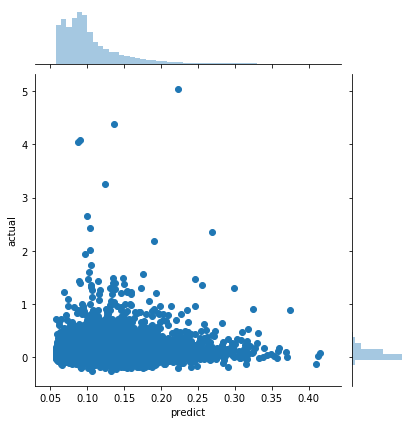

In [115]:
sns.jointplot(data=result[label], x="predict", y="actual")

In [116]:
result
np.corrcoef(result[label]["predict"], result[label]["actual"])

array([[1.       , 0.1324633],
       [0.1324633, 1.       ]])

Text(0.5, 0, 'Random Forest Feature Importance')

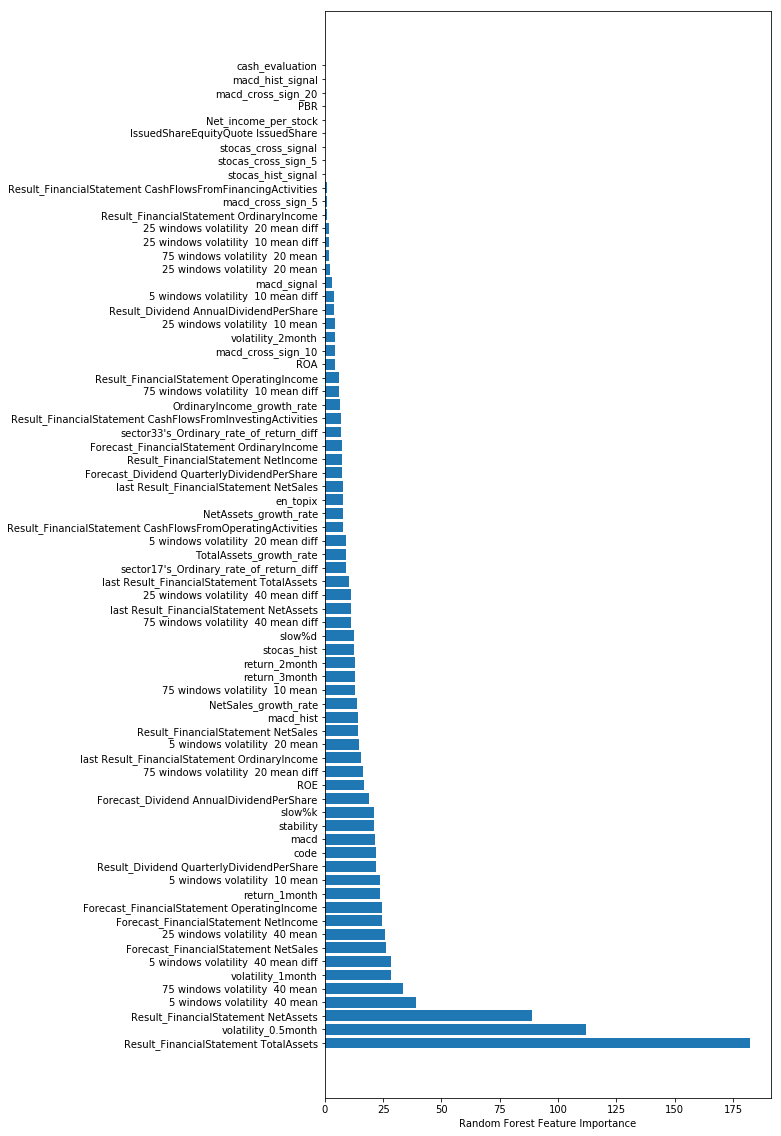

In [113]:
importance = pd.DataFrame(pred_model.feature_importance(importance_type='gain'), index=train_X[label].columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
fig, ax = plt.subplots(figsize=(8, 20))
ax.barh(importance.index, importance["importance"])
ax.set_xlabel("Random Forest Feature Importance")

In [117]:
def save_model(model, label, model_path="../opt/model"):
    # モデル保存先ディレクトリを作成
    os.makedirs(model_path, exist_ok=True)
    with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
        # モデルをpickle形式で保存
        pickle.dump(model, f)

In [149]:
# モデルを定義
models = {
    "gbm": lightgbm
}


# 学習済みモデル保存用
trained_models = dict()
# 結果保存用
all_results = dict()
# モデル毎に処理
for model in tqdm(models.keys()):
    all_results[model] = dict()
    trained_models[model] = dict()
    result = dict()
    trained_models[model] = dict()
    # 目的変数毎に処理
    for label in tqdm(labels):
        if len(test_X[label]) > 0:
            params = {'metric': 'rmse',
                      'max_depth' : 9}
            lgb_train = lgb.Dataset(train_X[label], train_y[label])
            lgb_eval = lgb.Dataset(val_X[label], val_y[label] )

            # 学習
            pred_model =lgb.train(params,
                            lgb_train,
                            valid_sets=lgb_eval,
                            num_boost_round=10000,
                            early_stopping_rounds=100,
                            verbose_eval=50)
            print(label)
            """
            # 学習済みモデル保存
                trained_models[model][col][label] = pred_model
                # 結果データ作成
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                # 予測
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                # 実際の結果
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)
            """
            # 予測
            #predicted = gbm.predict(X_test)
            result[label] = pd.DataFrame(
                pred_model.predict(test_X[label]), columns=["predict"]
            )
            # 学習済みモデル保存
            trained_models[model][label] = pred_model
            # 結果データ作成
            result[label] = test_X[label][["code"]].copy()
            result[label]["datetime"] = test_X[label].index
            # 予測
            result[label]["predict"] = pred_model.predict(test_X[label])
            result[label]["predict_dir"] = np.sign(result[label]["predict"])
            # 実際の結果
            result[label]["actual"] = test_y[label].values
            result[label]["actual_dir"] = np.sign(result[label]["actual"])
            result[label].dropna(inplace=True)

        all_results[model] = result

  0%|          | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15440
[LightGBM] [Info] Number of data points in the train set: 40279, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.044727
Training until validation scores don't improve for 100 rounds



 17%|█▋        | 1/6 [00:01<00:06,  1.27s/it]

[50]	valid_0's rmse: 0.0674104
[100]	valid_0's rmse: 0.0677267
Early stopping, best iteration is:
[13]	valid_0's rmse: 0.0671515
label_low_5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 40323, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info


 33%|███▎      | 2/6 [00:02<00:05,  1.33s/it]

[50]	valid_0's rmse: 0.0729193
[100]	valid_0's rmse: 0.0731728
Early stopping, best iteration is:
[12]	valid_0's rmse: 0.0723949
label_low_10


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051207 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 40328, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.091849
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.159901
[100]	valid_


 50%|█████     | 3/6 [00:04<00:04,  1.36s/it]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15440
[LightGBM] [Info] Number of data points in the train set: 40279, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 0.047593
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.0989156



 67%|██████▋   | 4/6 [00:05<00:02,  1.50s/it]

[100]	valid_0's rmse: 0.0995184
Early stopping, best iteration is:
[14]	valid_0's rmse: 0.0984428
label_high_5
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 40328, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replac


 83%|████████▎ | 5/6 [00:08<00:01,  1.68s/it]

[100]	valid_0's rmse: 0.0836414
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.0811613
label_low_20
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15439
[LightGBM] [Info] Number of data points in the train set: 40323, number of used features: 70
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Find whitespaces in feature_names, replace


100%|██████████| 1/1 [00:09<00:00,  9.83s/it]

Early stopping, best iteration is:
[19]	valid_0's rmse: 0.121556
label_high_10


In [150]:
results = []
for model in all_results.keys():
    tmp = pd.concat(all_results[model])
    tmp["model"] = model
    results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results.head(5)

code   datetime   predict  predict_dir   actual  \
label_high_10 2020-02-07  1301 2020-02-07  0.041433          1.0  0.07749   
              2020-05-12  1301 2020-05-12  0.053713          1.0  0.01048   
              2020-08-07  1301 2020-08-07  0.042162          1.0  0.00498   
              2020-11-06  1301 2020-11-06  0.042530          1.0  0.02444   
              2020-02-05  1332 2020-02-05  0.057402          1.0  0.04982   

                          actual_dir model          label  
label_high_10 2020-02-07         1.0   gbm  label_high_10  
              2020-05-12         1.0   gbm  label_high_10  
              2020-08-07         1.0   gbm  label_high_10  
              2020-11-06         1.0   gbm  label_high_10  
              2020-02-05         1.0   gbm  label_high_10

In [154]:
# 結果保存用変数
all_metrics = []

# データセット毎に処理
matrix = dict()
# モデル毎に処理
for model in models:
    # 目的変数毎に処理
    for label in labels:
        # 処理対象データに絞り込み
        tmp_df = results[(results["label"] == label)]
        rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
        # 精度
        accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
        # 相関係数
        corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
        # 順位相関
        spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
        # 結果を保存
        matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
    res = pd.DataFrame.from_dict(matrix).T
    res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
    all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

index       RMSE  accuracy spearman_corr       corr   R^2 score  \
0    label_low_5  0.0636909   0.79389      0.226626   0.233835   0.0546786   
1   label_low_10  0.0691345  0.825771      0.245301   0.264183   0.0697928   
2  label_high_20   0.166009  0.815492     0.0697456   0.132463   0.0175465   
3   label_high_5  0.0918373  0.731311     0.0362956  0.0997569  0.00995145   
4   label_low_20  0.0785729  0.853755      0.220638   0.249949   0.0624747   
5  label_high_10   0.113034  0.773269     0.0567222   0.123456   0.0152415   

                                             feature model # of samples  
0              Result_FinancialStatement NetSales...   gbm        14206  
1              Result_FinancialStatement NetSales...   gbm        14171  
2              Result_FinancialStatement NetSales...   gbm        13956  
3              Result_FinancialStatement NetSales...   gbm        14206  
4              Result_FinancialStatement NetSales...   gbm        13956  
5              Result_FinancialStatement NetSales...   gbm        14171

In [156]:
numeric_cols = ["RMSE","accuracy","spearman_corr","corr","R^2 score"]
for col in numeric_cols:
    all_metrics[col] = all_metrics[col].astype(float)
# indexとデータセット毎に平均を計算
agg = all_metrics.reset_index().groupby(["index"]).agg("mean")
agg

RMSE  accuracy  spearman_corr      corr  R^2 score
index                                                                
label_high_10  0.113034  0.773269       0.056722  0.123456   0.015241
label_high_20  0.166009  0.815492       0.069746  0.132463   0.017547
label_high_5   0.091837  0.731311       0.036296  0.099757   0.009951
label_low_10   0.069134  0.825771       0.245301  0.264183   0.069793
label_low_20   0.078573  0.853755       0.220638  0.249949   0.062475
label_low_5    0.063691  0.793890       0.226626  0.233835   0.054679

In [162]:
# 保存した学習済みモデルから、提出するモデルを選択してpickle形式で保存します。
# 使用するモデルや特徴量を変更する際は、学習時と推論時で同一の特徴量をモデルに
# 入力するために提出用のpredictor.pyについても変更する必要があることにご注意ください。

# モデルの保存先を指定します。
model_path = "../opt/ml/model"
# モデルの種類
models = ["gbm"]
# 使用する特徴量カラム
columns = ["fundamental+technical"]
# 目的変数
labels = [
    "label_high_20",
    "label_low_20",
]

# モデル毎に処理
for model in models:
    # 特徴量毎に処理
    # 目的変数毎に処理
    for label in labels:
        # 学習済みモデルを取得
        pred_model = trained_models[model][label]
        # モデルを保存
        save_model(pred_model, label, model_path=model_path)